In [1]:
import polars as pl
import openai
import unicodedata
import re
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
def normalize_text(s: str) -> str:
    # lowercasing, unicode normalization, removal of weird punctuation, extra whitespace
    if s is None:
        return ""
    # normalize unicode (e.g. cyrillic normalization)
    s = unicodedata.normalize("NFKC", s)
    s = s.lower()
    # remove extra spaces
    s = re.sub(r"\s+", " ", s).strip()
    # optional: remove non-cyrillic/latin punctuation or map them
    return s

def tokenize_simple(s: str) -> list[str]:
    # simple whitespace + punctuation split
    # you can expand with better tokenization (morphology, ru / by lexicons, etc.)
    s2 = re.sub(r"[^\wа-яёА-ЯЁ]+", " ", s)
    return s2.split()

In [3]:

client = openai.OpenAI(api_key=os.getenv("SCIBOX_API_KEY"), base_url="https://llm.t1v.scibox.tech/v1")


In [4]:
from sentence_transformers import SentenceTransformer
import torch

embedding_model = SentenceTransformer("BAAI/bge-m3")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
embedding_model = embedding_model.to(device)

# A batched version (for speed)
def get_embeddings_batch_local(texts: list[str]) -> list[list[float]]:
    return embedding_model.encode(texts)

/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [5]:
def get_original_data() -> tuple[list[str], list[list[float]]]:
    data = pl.read_csv("./data.csv", separator=";")
    df = data.with_columns([
        pl.col("text").map_elements(normalize_text).alias("query_norm"),
        pl.col("answer_pattern").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("subcategory").map_elements(normalize_text).alias("cat_fine_norm"),
    ])
    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    df = df.drop("priority").drop("tags")
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()

def get_augumented_data() -> tuple[list[str], list[list[float]]]:
    data = pl.read_csv("./data_extended.csv", separator=";")[262:]
    df = data.with_columns([
        pl.col("text").map_elements(normalize_text).alias("query_norm"),
        pl.col("answer_pattern").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("subcategory").map_elements(normalize_text).alias("cat_fine_norm"),
    ])
    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    df = df.drop("priority").drop("tags")
    print("Augmented data size:", df.height)
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()

In [6]:
def get_bitext_data() -> tuple[list[str], list[str]]:
    data = pl.read_csv("./bitext.csv", separator=",")
    df = data.with_columns([
        pl.col("instruction").map_elements(normalize_text).alias("query_norm"),
        pl.col("response").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("intent").map_elements(normalize_text).alias("cat_fine_norm"),

    ])
    df = df.drop("flags")
    
    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()
# get_bitext_data()

In [7]:
def get_tickets_it_sup() -> tuple[list[str], list[list[float]]]:
    data = pl.read_csv("./tickets.csv", separator=",")
    df = data.with_columns([
        pl.col("text").map_elements(normalize_text).alias("query_norm"),
        pl.col("answer").map_elements(normalize_text).alias("answer_norm"),
        pl.col("category").map_elements(normalize_text).alias("cat_coarse_norm"),
        pl.col("subcategory").map_elements(normalize_text).alias("cat_fine_norm"),
    ])

    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()

In [8]:
def get_russian_intent_dataset() -> tuple[list[str], list[list[float]]]:
    data = pl.read_csv("./russian_intent_dataset.tsv", separator="\t")
    df = data.with_columns([
    pl.col("мне нужна справка").map_elements(normalize_text).alias("query_norm"),
    pl.col("statement_general").map_elements(normalize_text).alias("cat_fine_norm"),
    ])
    print(df)

    queries = df.select("query_norm").unique().to_series().to_list()
    embs = get_embeddings_batch_local(queries)
    query_to_emb = {q: e for q, e in zip(queries, embs)}
    
    def query_to_emb_as_list(q: str) -> list[float]:
        return query_to_emb.get(q, None)

    df = df.with_columns([
        pl.col("query_norm").map_elements(query_to_emb_as_list, return_dtype=list[float]).alias("query_emb")
    ])
    

    return df["cat_fine_norm"].to_list(), df["query_emb"].to_list()

In [9]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_recall_fscore_support, top_k_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np
y, X = get_original_data()
y_aug, X_aug = get_augumented_data()
X_aug, X_aug_test , y_aug, y_aug_test  = train_test_split(
    X_aug, y_aug, test_size=0.4, random_state=42, stratify=y_aug
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train += X_aug
y_train += y_aug
X_test += X_aug_test
y_test += y_aug_test


# aggressive test to see if aug is compatible with original data
# X_train, X_test, y_train, y_test = X_aug, X, y_aug, y

# --- 3) OpenAI embeddings (batched) -----------------------------------------


# L2-normalize for cosine via dot product trick
def l2norm(a):
    n = np.linalg.norm(a, axis=1, keepdims=True) + 1e-9
    return a / n

E_train = l2norm(X_train)
E_test  = l2norm(X_test)


Augmented data size: 1054


In [10]:
print(y_train)

['банковские карточки', 'кредитные карты - plat/on', 'банковские карточки', 'дебетовые карты - signature', 'дебетовые карты - more', 'кредиты', 'дебетовые карты - signature', 'банковские карточки', 'рублевые - суперсемь', 'потребительские - старт', 'вклады и депозиты', 'карты рассрочки - кстати', 'карты рассрочки - кстати', 'кредиты', 'карты рассрочки - кстати', 'экспресс-кредиты - в магазинах-партнерах', 'банковские карточки', 'валютные - eur', 'кредитные карты - plat/on', 'кредитные карты - портмоне 2.0', 'рублевые - мои условия онлайн', 'кредиты', 'банковские карточки', 'банковские карточки', 'банковские карточки', 'кредитные карты - портмоне 2.0', 'дебетовые карты - форсаж', 'вклады и депозиты', 'карты рассрочки - черепаха', 'кредиты', 'карты рассрочки - кстати', 'валютные - rub', 'онлайн-сервисы', 'экспресс-кредиты - на роднае', 'кредитные карты - отличник', 'дебетовые карты - signature', 'кредиты', 'дебетовые карты - signature', 'банковские карточки', 'потребительские - легко пла

In [11]:

# --- 4) Simple kNN (cosine) to get y_pred (top-1) ---------------------------
# For cosine with NearestNeighbors, use metric="cosine" (it returns distances = 1 - cosine_sim)
knn = NearestNeighbors(n_neighbors=1, metric="cosine")
knn.fit(E_train)

dist, idx = knn.kneighbors(E_test, return_distance=True)   # idx: (n_test, 1)
# Map neighbor index to label
y_train_arr = np.array(y_train)
y_pred = y_train_arr[idx[:,0]].tolist()

# --- 5) Metrics: y_true / y_pred -------------------------------------------
y_true = y_test  # for clarity

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy:  {acc:.4f}")
print(f"Macro F1:  {macro_f1:.4f}")
print("\nPer-class report:\n", classification_report(y_true, y_pred, digits=4))

Accuracy:  0.7273
Macro F1:  0.7297

Per-class report:
                                           precision    recall  f1-score   support

     автокредиты - автокредит без залога     0.9091    1.0000    0.9524        10
                     банковские карточки     0.6981    0.7115    0.7048        52
                          валютные - cny     1.0000    0.8750    0.9333         8
                          валютные - eur     0.6250    0.7143    0.6667         7
                          валютные - rub     0.5385    0.8750    0.6667         8
                          валютные - usd     0.5000    0.5714    0.5333         7
                       вклады и депозиты     0.8056    0.7838    0.7945        37
              дебетовые карты - infinite     1.0000    0.8000    0.8889        10
                  дебетовые карты - more     0.8235    0.6667    0.7368        21
             дебетовые карты - signature     0.6923    0.7500    0.7200        12
            дебетовые карты - комплимент 

/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/run/media/inejka/USB_SSD_DATA/Python/t1-smart-support/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

Top 15 Most Common Misclassifications:
True: банковские карточки                      → Predicted: кредиты                                  | Count: 6
True: кредиты                                  → Predicted: потребительские - на всё про всё         | Count: 5
True: кредиты                                  → Predicted: онлайн кредиты - проще в онлайн          | Count: 5
True: рублевые - мои условия онлайн            → Predicted: вклады и депозиты                        | Count: 4
True: рублевые - мои условия                   → Predicted: валютные - usd                           | Count: 3
True: банковские карточки                      → Predicted: дебетовые карты - more                   | Count: 3
True: карты рассрочки - кстати                 → Predicted: банковские карточки                      | Count: 3
True: дебетовые карты - more                   → Predicted: карты рассрочки - черепаха               | Count: 3
True: дебетовые карты - форсаж                 → Predicted: креди

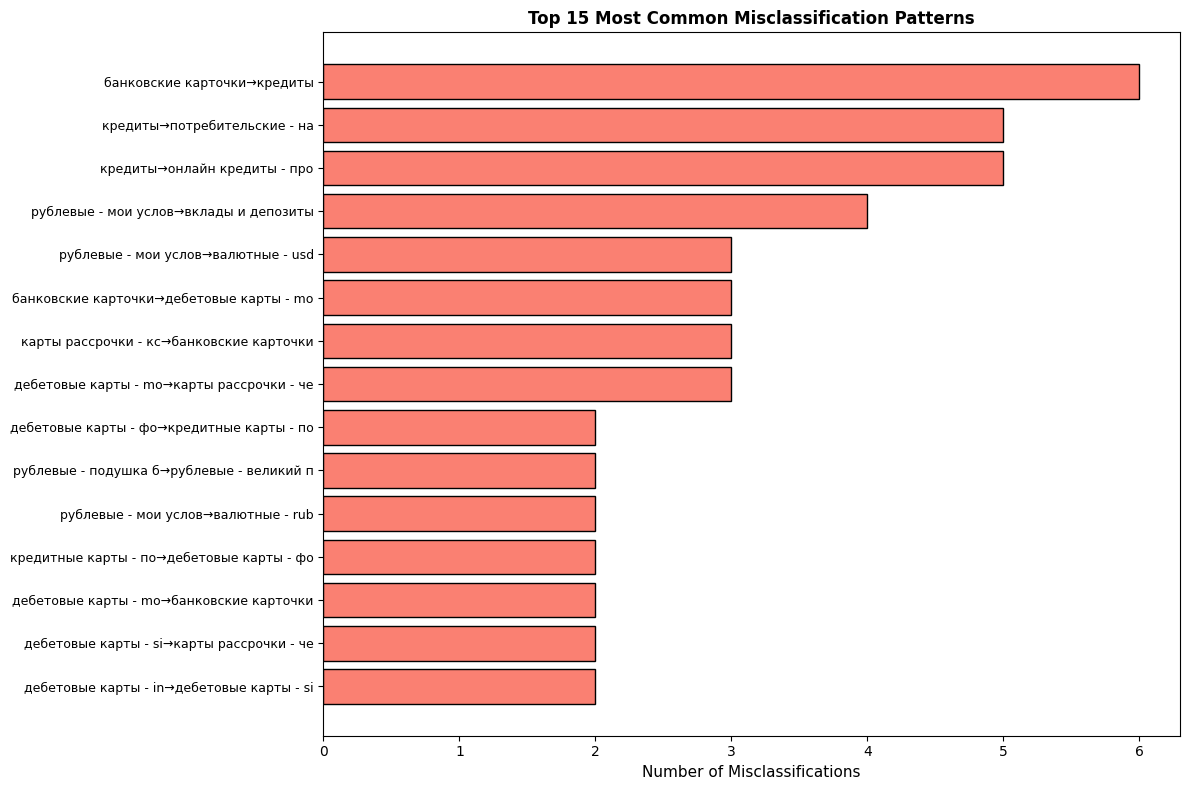

In [12]:
import matplotlib.pyplot as plt
# Most Common Misclassifications
misclassifications = []
for true_label, pred_label in zip(y_true, y_pred):
    if true_label != pred_label:
        misclassifications.append((true_label, pred_label))

if misclassifications:
    from collections import Counter
    most_common_errors = Counter(misclassifications).most_common(15)
    
    print("Top 15 Most Common Misclassifications:")
    print("="*80)
    for (true_label, pred_label), count in most_common_errors:
        print(f"True: {true_label[:40]:40} → Predicted: {pred_label[:40]:40} | Count: {count}")
    
    # Visualize
    error_labels = [f"{t[:20]}→{p[:20]}" for (t, p), _ in most_common_errors]
    error_counts = [count for _, count in most_common_errors]
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(error_labels)), error_counts, color='salmon', edgecolor='black')
    plt.yticks(range(len(error_labels)), error_labels, fontsize=9)
    plt.xlabel('Number of Misclassifications', fontsize=11)
    plt.title('Top 15 Most Common Misclassification Patterns', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found!")

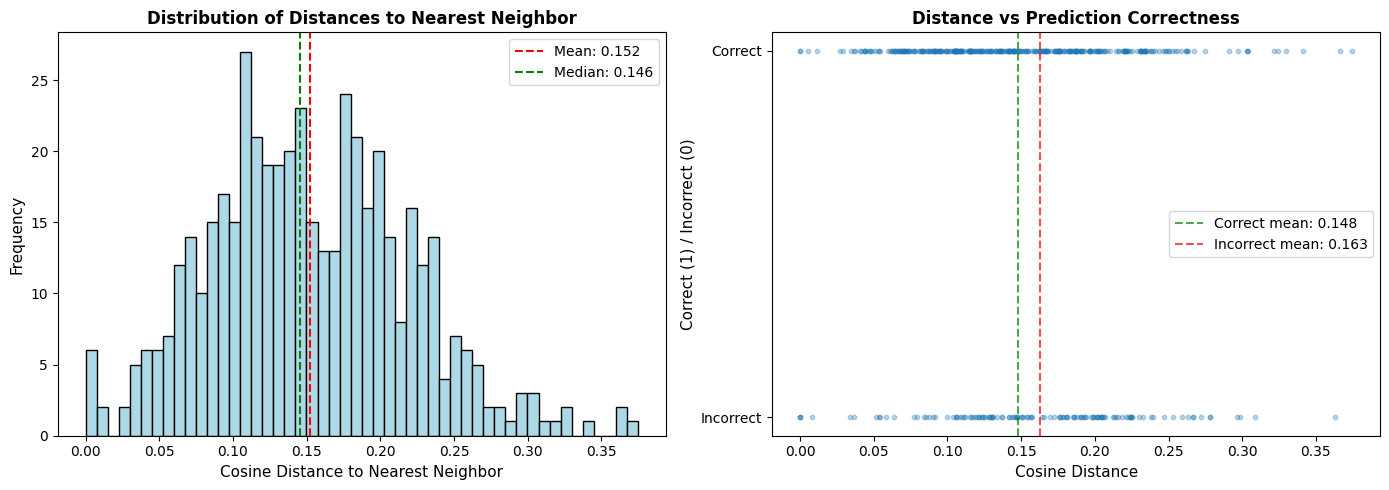

Mean distance for correct predictions: 0.1478
Mean distance for incorrect predictions: 0.1629
Accuracy: 0.7273 (344/473)


In [13]:
# Distance Analysis - How confident is the model?
plt.figure(figsize=(14, 5))

# Distance distribution
plt.subplot(1, 2, 1)
plt.hist(dist.flatten(), bins=50, edgecolor='black', color='lightblue')
plt.xlabel('Cosine Distance to Nearest Neighbor', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Distances to Nearest Neighbor', fontsize=12, fontweight='bold')
plt.axvline(dist.mean(), color='red', linestyle='--', label=f'Mean: {dist.mean():.3f}')
plt.axvline(np.median(dist), color='green', linestyle='--', label=f'Median: {np.median(dist):.3f}')
plt.legend()

# Distance vs Correctness
plt.subplot(1, 2, 2)
correct = np.array([1 if yt == yp else 0 for yt, yp in zip(y_true, y_pred)])
plt.scatter(dist.flatten(), correct, alpha=0.3, s=10)
plt.xlabel('Cosine Distance', fontsize=11)
plt.ylabel('Correct (1) / Incorrect (0)', fontsize=11)
plt.title('Distance vs Prediction Correctness', fontsize=12, fontweight='bold')
plt.yticks([0, 1], ['Incorrect', 'Correct'])

# Add mean distances for correct/incorrect
correct_dist_mean = dist[correct == 1].mean()
incorrect_dist_mean = dist[correct == 0].mean()
plt.axvline(correct_dist_mean, color='green', linestyle='--', alpha=0.7,
            label=f'Correct mean: {correct_dist_mean:.3f}')
plt.axvline(incorrect_dist_mean, color='red', linestyle='--', alpha=0.7,
            label=f'Incorrect mean: {incorrect_dist_mean:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Mean distance for correct predictions: {correct_dist_mean:.4f}")
print(f"Mean distance for incorrect predictions: {incorrect_dist_mean:.4f}")
print(f"Accuracy: {correct.mean():.4f} ({correct.sum()}/{len(correct)})")

In [14]:
# --- 6) Visualizations -------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

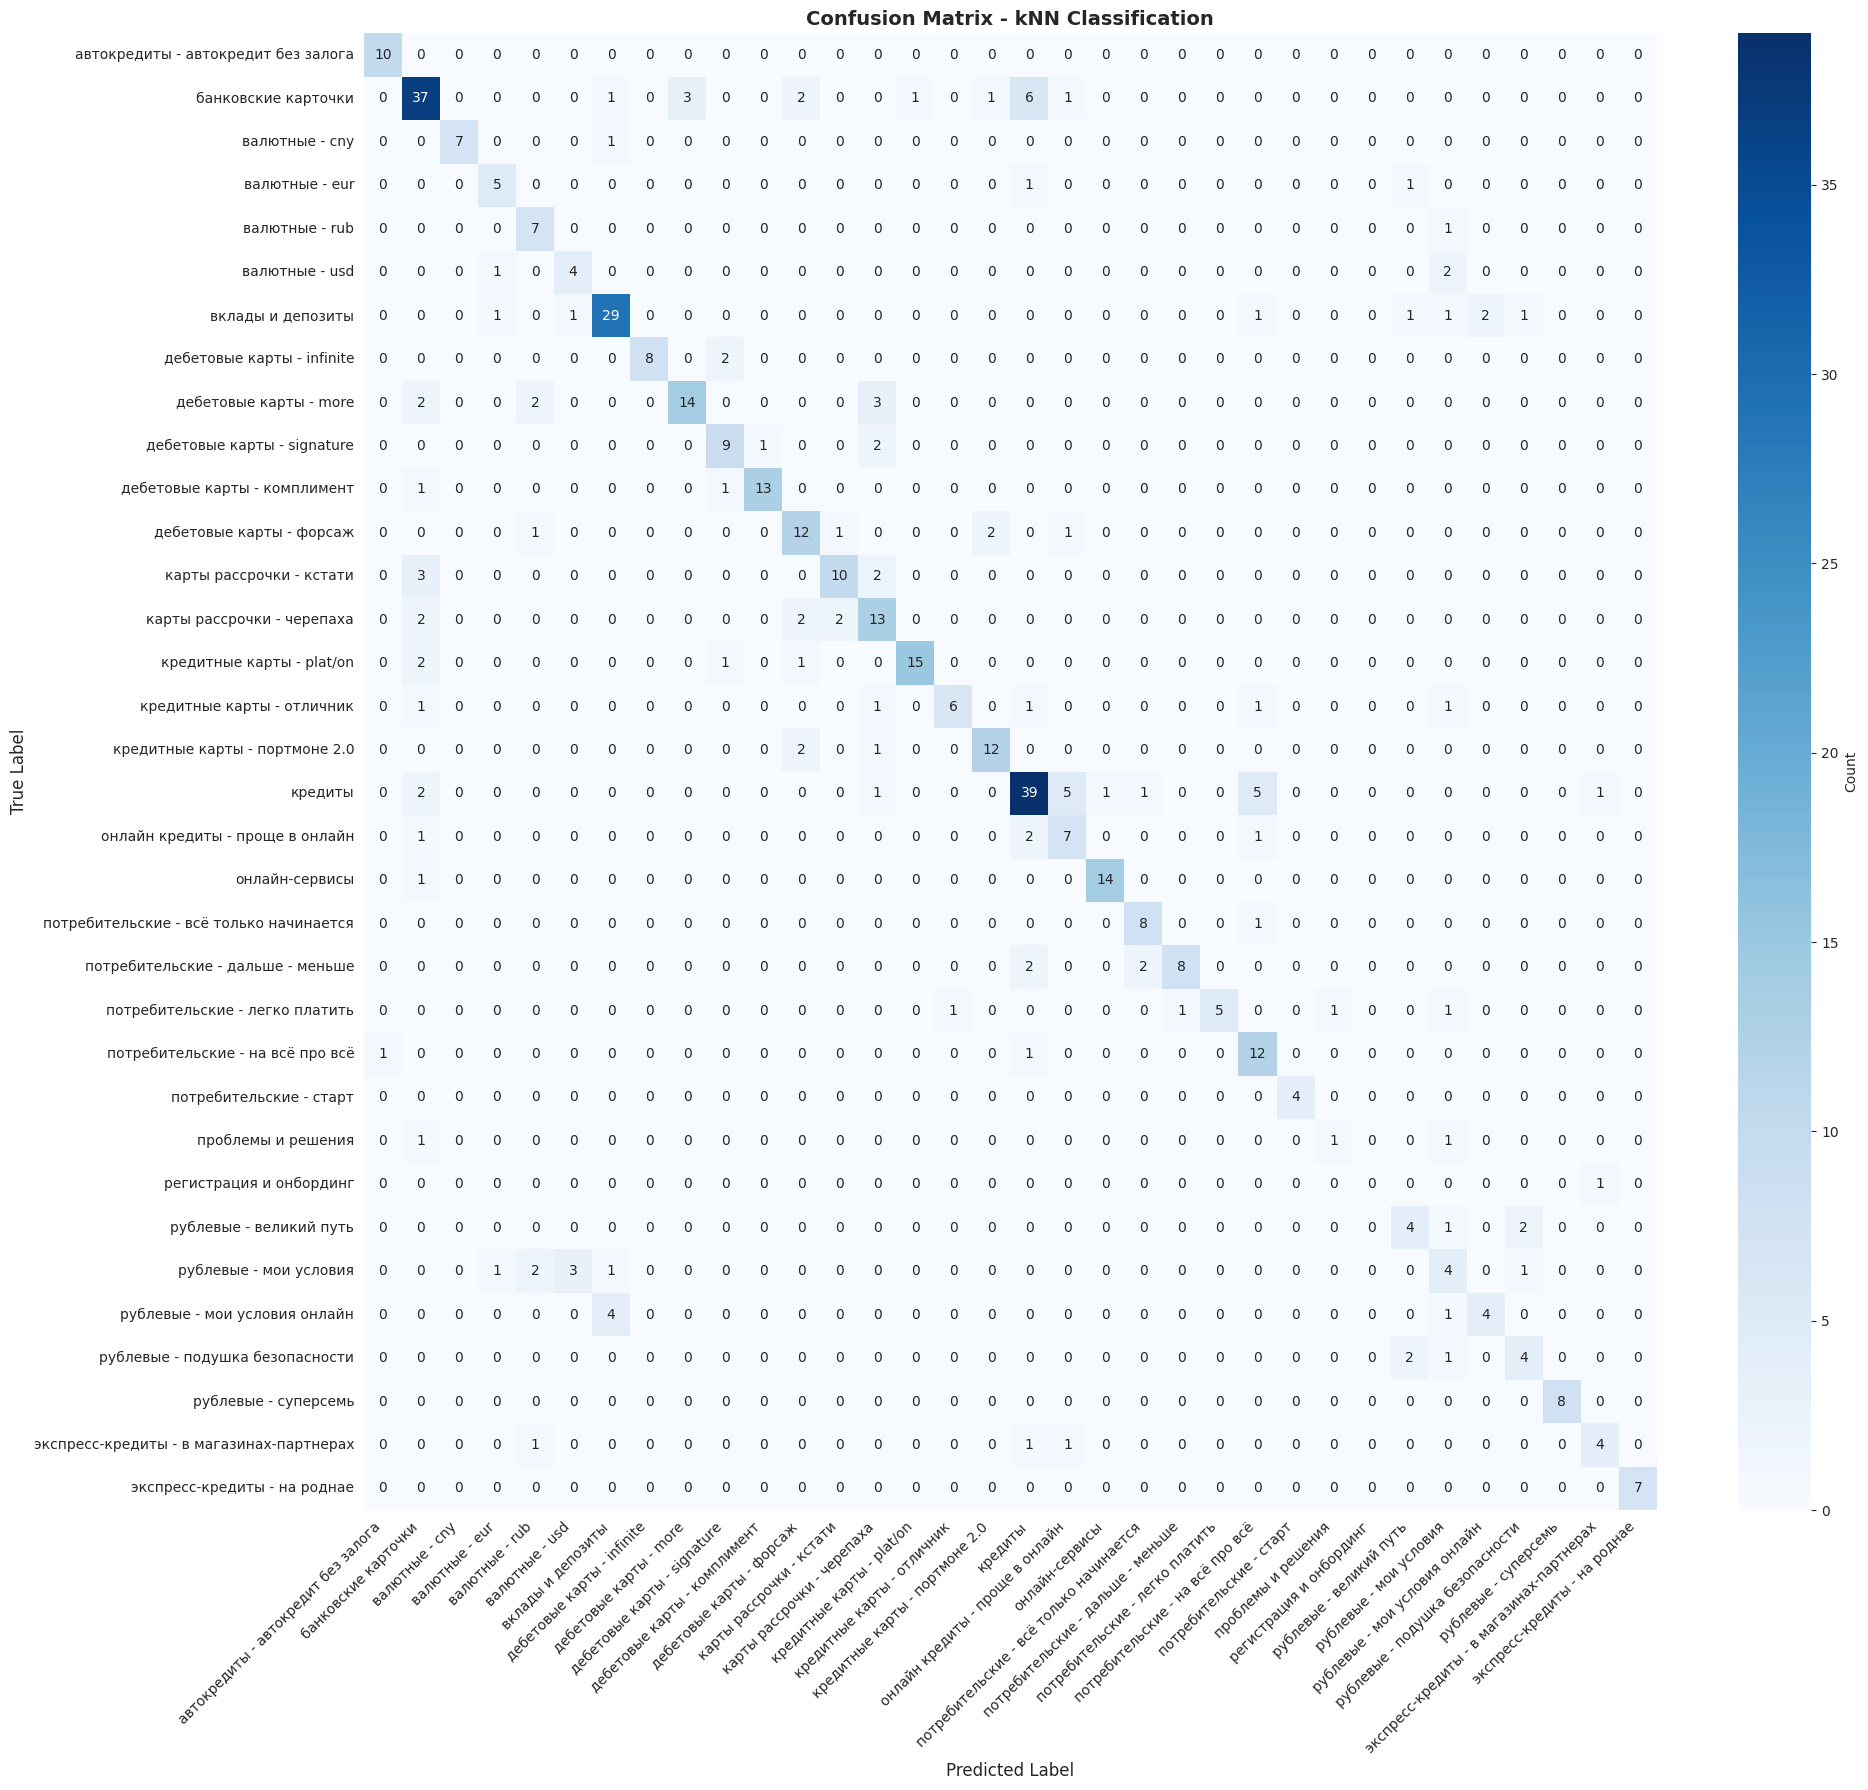

Total classes: 34
Total predictions: 473


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
unique_labels = sorted(list(set(y_true + y_pred)))

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - kNN Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Total classes: {len(unique_labels)}")
print(f"Total predictions: {len(y_true)}")

In [16]:
# Per-class Performance Analysis
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, 
                                                                   labels=unique_labels,
                                                                   zero_division=0)

# Create a dataframe for easier visualization
performance_df = pd.DataFrame({
    'Class': unique_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("Top 10 best performing classes:")
print(performance_df.head(10).to_string(index=False))
print("\n" + "="*80 + "\n")
print("Top 10 worst performing classes:")
print(performance_df.tail(10).to_string(index=False))

Top 10 best performing classes:
                              Class  Precision   Recall  F1-Score  Support
               рублевые - суперсемь   1.000000 1.000000  1.000000        8
       экспресс-кредиты - на роднае   1.000000 1.000000  1.000000        7
            потребительские - старт   1.000000 1.000000  1.000000        4
автокредиты - автокредит без залога   0.909091 1.000000  0.952381       10
                     онлайн-сервисы   0.933333 0.933333  0.933333       15
                     валютные - cny   1.000000 0.875000  0.933333        8
       дебетовые карты - комплимент   0.928571 0.866667  0.896552       15
         дебетовые карты - infinite   1.000000 0.800000  0.888889       10
          кредитные карты - plat/on   0.937500 0.789474  0.857143       19
     кредитные карты - портмоне 2.0   0.800000 0.800000  0.800000       15


Top 10 worst performing classes:
                                   Class  Precision   Recall  F1-Score  Support
              карты рассрочк

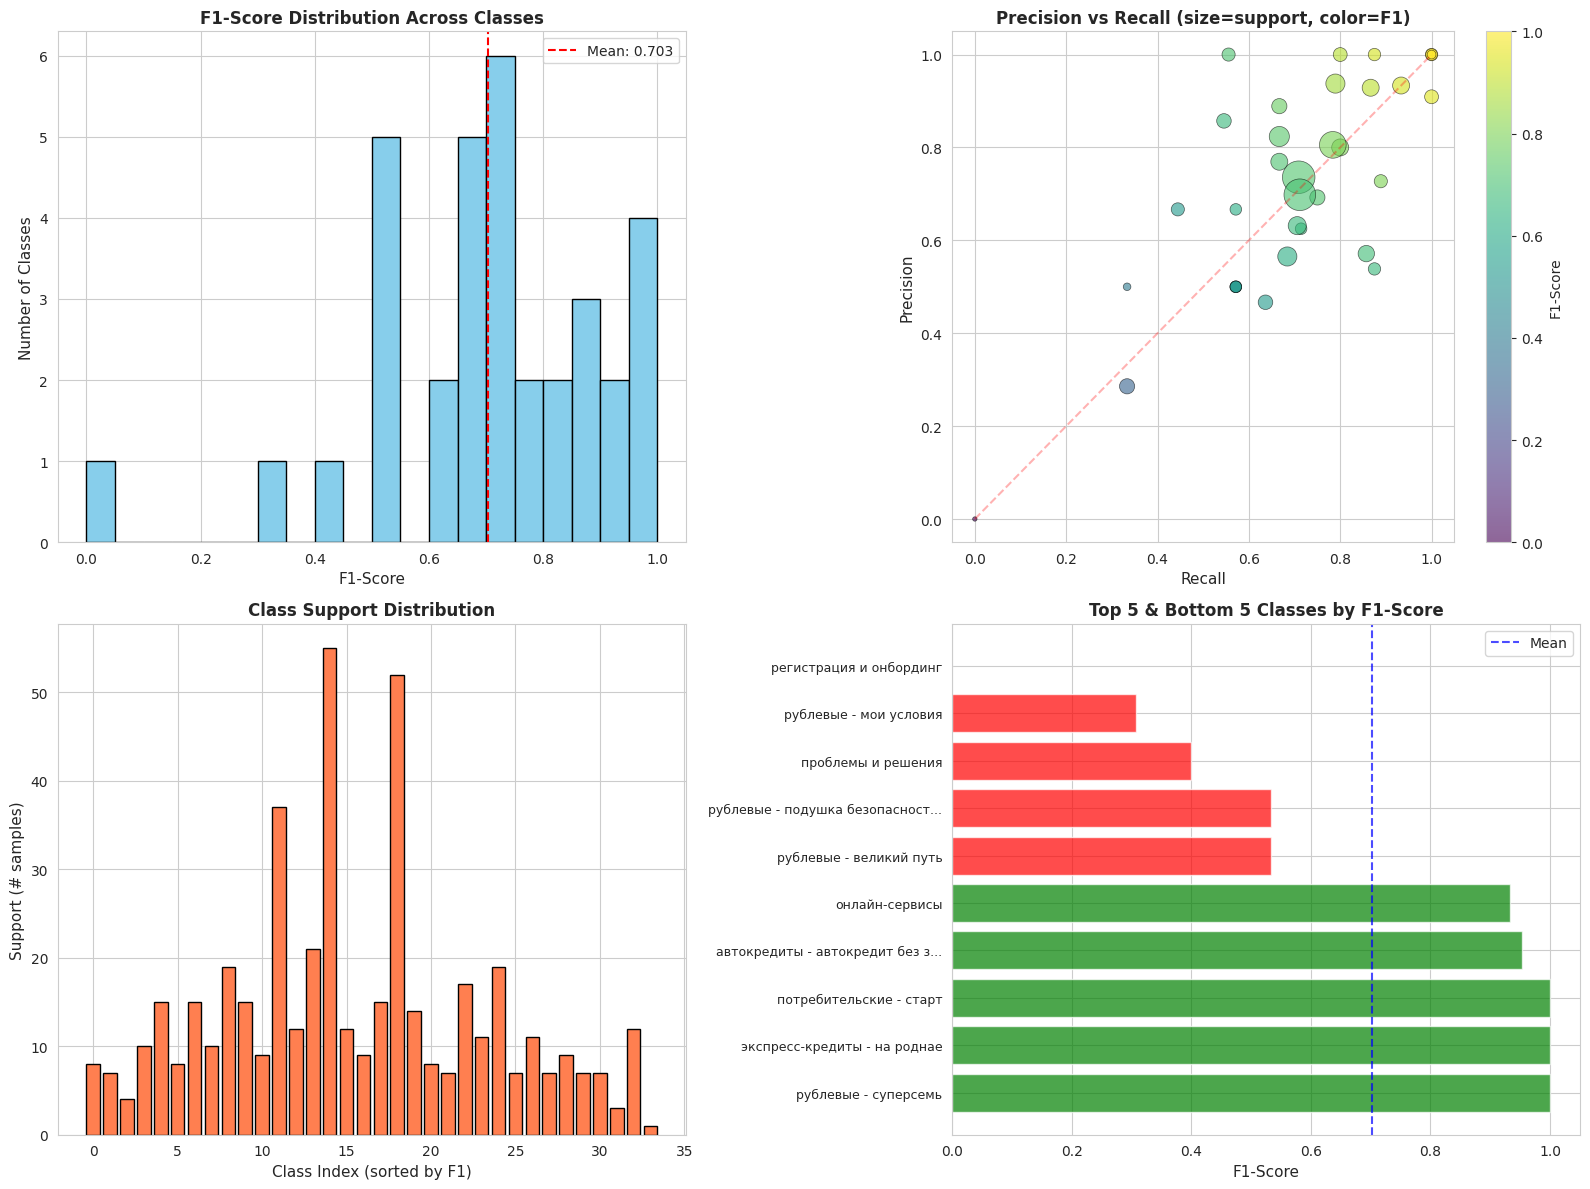

In [17]:
# Visualize per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score distribution
axes[0, 0].hist(performance_df['F1-Score'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('F1-Score', fontsize=11)
axes[0, 0].set_ylabel('Number of Classes', fontsize=11)
axes[0, 0].set_title('F1-Score Distribution Across Classes', fontsize=12, fontweight='bold')
axes[0, 0].axvline(performance_df['F1-Score'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {performance_df["F1-Score"].mean():.3f}')
axes[0, 0].legend()

# Precision vs Recall scatter
scatter = axes[0, 1].scatter(performance_df['Recall'], performance_df['Precision'], 
                             s=performance_df['Support']*10, alpha=0.6, c=performance_df['F1-Score'],
                             cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision vs Recall (size=support, color=F1)', fontsize=12, fontweight='bold')
axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='F1-Score')

# Support distribution
axes[1, 0].bar(range(len(performance_df)), performance_df['Support'].values, 
               color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Class Index (sorted by F1)', fontsize=11)
axes[1, 0].set_ylabel('Support (# samples)', fontsize=11)
axes[1, 0].set_title('Class Support Distribution', fontsize=12, fontweight='bold')

# Top/Bottom performers comparison
top_bottom = pd.concat([performance_df.head(5), performance_df.tail(5)])
x_pos = range(len(top_bottom))
axes[1, 1].barh(x_pos, top_bottom['F1-Score'], color=['green']*5 + ['red']*5, alpha=0.7)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels([c[:30] + '...' if len(c) > 30 else c for c in top_bottom['Class']], 
                            fontsize=9)
axes[1, 1].set_xlabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Top 5 & Bottom 5 Classes by F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].axvline(performance_df['F1-Score'].mean(), color='blue', linestyle='--', 
                    label='Mean', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

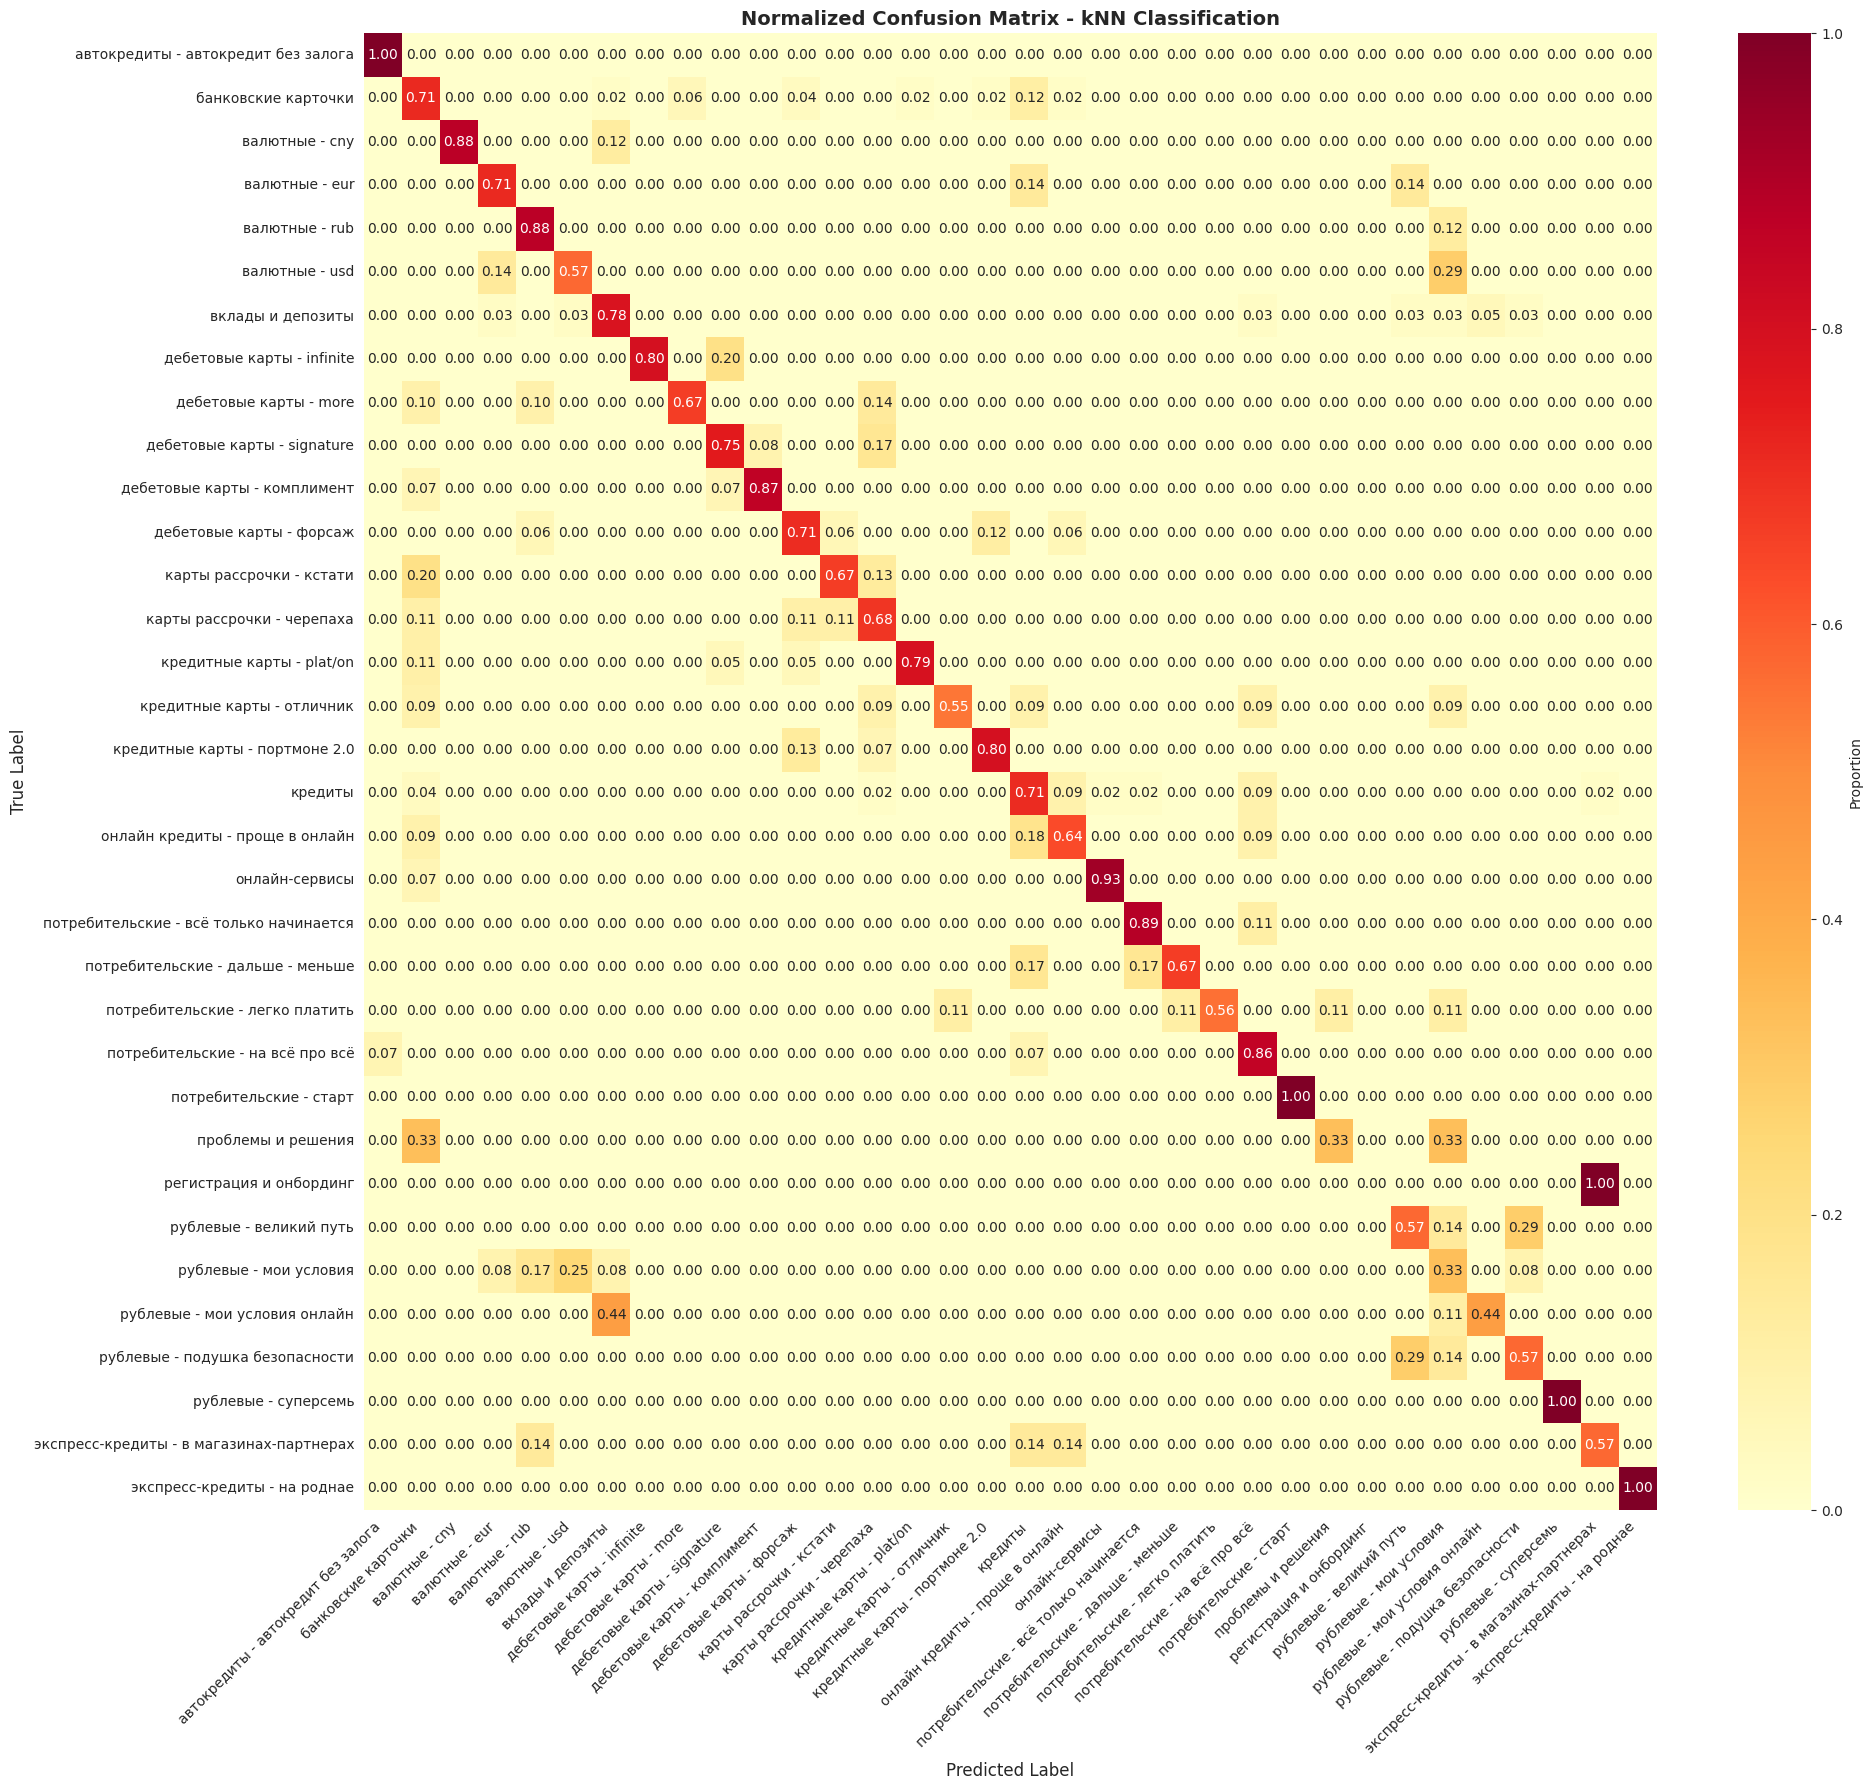

In [18]:
# Normalized Confusion Matrix (showing proportions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix - kNN Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
test = "Какая доходность CNY?"
test = normalize_text(test)

emb = get_embeddings_batch_local([test])
emb = l2norm( emb)
dist, idx = knn.kneighbors(emb, return_distance=True)   

In [20]:
y_train_arr = np.array(y_train)
y_pred = y_train_arr[idx[:,0]].tolist()
y_pred

['валютные - cny']

In [21]:
# based_hierarchical_v2.py — Fixed version with true hierarchical training
import polars as pl
import numpy as np
import json
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# ---------- Config ----------
MIN_CLASS_SUPPORT = 5  # Drop classes with fewer samples
PARENT_C = 5.0  # Strong regularization for parent (5 classes)
CHILD_C = 2.0   # Medium regularization for children (7-8 per parent)
ALPHA = 0.25    # Prototype shrinkage (less aggressive)

def l2(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a)
    if a.ndim == 1:
        n = np.linalg.norm(a) + 1e-9
        return a / n
    if a.ndim == 2:
        n = np.linalg.norm(a, axis=1, keepdims=True) + 1e-9
        return a / n
    raise ValueError("l2() expects 1-D or 2-D array")

# ---------- Load and clean data ----------
try:
    y, X = get_original_data()
    y_aug, X_aug = get_augumented_data()
    
    
    X_aug, X_aug_test, y_aug, y_aug_test = train_test_split(
        X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train += X_aug
    y_train += y_aug
    X_test += X_aug_test
    y_test += y_aug_test
    
    print(f"Data sizes -> train: {len(X_train)}, test: {len(X_test)}")
    print(f"Synthetic ratio: {len(y_aug)/(len(y)-len(y_test)):.1f}:1")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# ---------- Load taxonomy ----------
label_desc = pl.read_csv("label_desc.csv")
sub_names_tax = label_desc["subcategory"].map_elements(normalize_text).to_list()
cat_names_tax = label_desc["category"].map_elements(normalize_text).to_list()
label_texts = label_desc["generated_label"].map_elements(normalize_text).to_list()

sub2cat = {s: c for s, c in zip(sub_names_tax, cat_names_tax)}

# ---------- Clean toxic classes ----------
# Count support per class in training data
class_counts = Counter(y_train)
toxic_classes = {cls for cls, cnt in class_counts.items() if cnt < MIN_CLASS_SUPPORT}

if toxic_classes:
    print(f"\n⚠️  Dropping {len(toxic_classes)} classes with <{MIN_CLASS_SUPPORT} samples:")
    for cls in sorted(toxic_classes):
        print(f"  - {cls} ({class_counts[cls]} samples)")
    
    # Remove from train
    mask_train = np.array([y not in toxic_classes for y in y_train])
    X_train = [x for x, m in zip(X_train, mask_train) if m]
    y_train = [y for y, m in zip(y_train, mask_train) if m]
    
    # Remove from test (for clean evaluation)
    mask_test = np.array([y not in toxic_classes for y in y_test])
    X_test = [x for x, m in zip(X_test, mask_test) if m]
    y_test = [y for y, m in zip(y_test, mask_test) if m]
    
    # Update taxonomy
    sub_names_tax = [s for s in sub_names_tax if s not in toxic_classes]
    cat_names_tax = [c for s, c in zip(label_desc["subcategory"].to_list(), cat_names_tax) 
                     if normalize_text(s) not in toxic_classes]
    label_texts = [t for s, t in zip(label_desc["subcategory"].to_list(), label_texts)
                   if normalize_text(s) not in toxic_classes]
    
    print(f"Cleaned data -> train: {len(X_train)}, test: {len(X_test)}")

# ---------- Build mappings ----------
sub2id = {name: i for i, name in enumerate(sub_names_tax)}
id2sub = {i: name for name, i in sub2id.items()}

cat2id, id2cat = {}, {}
for name in cat_names_tax:
    if name not in cat2id:
        cid = len(cat2id)
        cat2id[name], id2cat[cid] = cid, name

y_sub_train = np.array([sub2id[s] for s in y_train], dtype=np.int32)
y_cat_train = np.array([cat2id[sub2cat[s]] for s in y_train], dtype=np.int32)

y_sub_test = np.array([sub2id[s] for s in y_test], dtype=np.int32)
y_cat_test = np.array([cat2id[sub2cat[s]] for s in y_test], dtype=np.int32)

parent_map = np.array([cat2id[c] for c in cat_names_tax], dtype=np.int32)

N_SUB = len(sub2id)
N_CAT = len(cat2id)

print(f"\nTaxonomy: {N_SUB} subcategories across {N_CAT} parent categories")

# ---------- Embed ----------
X_train_emb = l2(np.array(X_train))
X_test_emb = l2(np.array(X_test))
desc_vecs = l2(get_embeddings_batch_local(label_texts))

# ---------- Build prototypes (NO DATA LEAKAGE) ----------
def build_protos(X_arr: np.ndarray, y_arr: np.ndarray, desc_vecs: np.ndarray) -> np.ndarray:
    """Build prototypes ONLY from training fold."""
    d = desc_vecs.shape[1]
    protos = np.zeros((N_SUB, d), dtype=np.float32)
    for i in range(N_SUB):
        idx = np.where(y_arr == i)[0]
        if len(idx) > 0:
            base = X_arr[idx].mean(0)
            protos[i] = l2((1 - ALPHA) * base + ALPHA * desc_vecs[i])
        else:
            protos[i] = desc_vecs[i]  # fallback to label text
    return protos

# ---------- Feature engineering ----------
def make_features_v2(x_vec: np.ndarray, protos: np.ndarray, parent_map: np.ndarray) -> np.ndarray:
    """Enhanced features: [sub_sim] + [parent_max] + [parent_mean] + [margin] + [top_parent_margin]"""
    sim_sub = protos @ x_vec
    
    # Parent aggregations
    sim_par_max = np.zeros(N_CAT, dtype=np.float32)
    sim_par_mean = np.zeros(N_CAT, dtype=np.float32)
    for c in range(N_CAT):
        mask = parent_map == c
        if mask.any():
            sim_par_max[c] = sim_sub[mask].max()
            sim_par_mean[c] = sim_sub[mask].mean()
    
    # Margins
    if sim_sub.size >= 2:
        top2 = np.partition(sim_sub, -2)[-2:]
        sub_margin = top2[1] - top2[0]
    else:
        sub_margin = 0.0
    
    if sim_par_max.size >= 2:
        top2_par = np.partition(sim_par_max, -2)[-2:]
        par_margin = top2_par[1] - top2_par[0]
    else:
        par_margin = 0.0
    
    return np.concatenate([sim_sub, sim_par_max, sim_par_mean, [sub_margin, par_margin]]).astype(np.float32)

# ---------- Two-stage hierarchical training ----------
class HierarchicalClassifier:
    def __init__(self, parent_C=5.0, child_C=2.0):
        self.parent_C = parent_C
        self.child_C = child_C
        self.parent_clf = None
        self.child_clfs = {}
        self.parent_scaler = None
        self.child_scalers = {}
        self.protos = None
    
    def fit(self, X_emb, y_sub, y_cat, protos):
        self.protos = protos
        
        # Stage 1: Train parent classifier
        X_feat = np.stack([make_features_v2(x, protos, parent_map) for x in X_emb])
        self.parent_scaler = StandardScaler().fit(X_feat)
        X_scaled = self.parent_scaler.transform(X_feat)
        
        self.parent_clf = LogisticRegression(
            C=self.parent_C, 
            max_iter=3000, 
            class_weight='balanced',
            random_state=42
        )
        self.parent_clf.fit(X_scaled, y_cat)
        
        # Optional: calibrate parent
        # self.parent_clf = CalibratedClassifierCV(self.parent_clf, cv=3, method='isotonic')
        # self.parent_clf.fit(X_scaled, y_cat)
        
        # Stage 2: Train child classifier per parent
        for parent_id in range(N_CAT):
            # Get samples belonging to this parent
            mask = y_cat == parent_id
            if mask.sum() < 2:
                continue
            
            X_parent = X_emb[mask]
            y_parent = y_sub[mask]
            
            # Get child subcategories for this parent
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if len(child_ids) == 1:
                # Only one child - deterministic
                self.child_clfs[parent_id] = None
                continue
            
            # Build features
            X_feat_child = np.stack([make_features_v2(x, protos, parent_map) for x in X_parent])
            scaler_child = StandardScaler().fit(X_feat_child)
            X_scaled_child = scaler_child.transform(X_feat_child)
            
            # Train child classifier
            clf_child = LogisticRegression(
                C=self.child_C,
                max_iter=3000,
                class_weight='balanced',
                random_state=42
            )
            clf_child.fit(X_scaled_child, y_parent)
            
            self.child_scalers[parent_id] = scaler_child
            self.child_clfs[parent_id] = clf_child
    
    def predict(self, X_emb):
        X_feat = np.stack([make_features_v2(x, self.protos, parent_map) for x in X_emb])
        X_scaled = self.parent_scaler.transform(X_feat)
        
        # Predict parents
        parents_pred = self.parent_clf.predict(X_scaled)
        
        # Predict children
        y_pred = np.zeros(len(X_emb), dtype=np.int32)
        
        for i, parent_id in enumerate(parents_pred):
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if len(child_ids) == 1:
                # Only one child
                y_pred[i] = child_ids[0]
            elif parent_id in self.child_clfs and self.child_clfs[parent_id] is not None:
                # Use child classifier
                x_feat = make_features_v2(X_emb[i], self.protos, parent_map)
                x_scaled = self.child_scalers[parent_id].transform([x_feat])
                y_pred[i] = self.child_clfs[parent_id].predict(x_scaled)[0]
            else:
                # Fallback: pick child with highest similarity
                sims = self.protos[child_ids] @ X_emb[i]
                y_pred[i] = child_ids[sims.argmax()]
        
        return y_pred
    
    def predict_proba(self, X_emb):
        """Return full probability matrix (for analysis)."""
        X_feat = np.stack([make_features_v2(x, self.protos, parent_map) for x in X_emb])
        X_scaled = self.parent_scaler.transform(X_feat)
        
        parent_probs = self.parent_clf.predict_proba(X_scaled)
        parents_pred = parent_probs.argmax(1)
        
        # Initialize full proba matrix
        probs = np.zeros((len(X_emb), N_SUB), dtype=np.float32)
        
        for i, parent_id in enumerate(parents_pred):
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if parent_id in self.child_clfs and self.child_clfs[parent_id] is not None:
                x_feat = make_features_v2(X_emb[i], self.protos, parent_map)
                x_scaled = self.child_scalers[parent_id].transform([x_feat])
                child_probs = self.child_clfs[parent_id].predict_proba(x_scaled)[0]
                
                # Map child probs to full matrix
                for j, child_id in enumerate(child_ids):
                    if j < len(child_probs):
                        probs[i, child_id] = parent_probs[i, parent_id] * child_probs[j]
            else:
                # Uniform over children
                probs[i, child_ids] = parent_probs[i, parent_id] / len(child_ids)
        
        return probs

# ---------- Honest CV evaluation ----------
print("\n" + "="*80)
print("5-FOLD CROSS-VALIDATION (NO ABSTENTION FILTERING)")
print("="*80)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_macro_list, f1_weighted_list = [], []
parent_f1_list = []

for fold, (tr, te) in enumerate(skf.split(X_train_emb, y_sub_train), 1):
    # Build protos on train fold ONLY
    P_fold = build_protos(X_train_emb[tr], y_sub_train[tr], desc_vecs)
    
    # Train hierarchical model
    hier_clf = HierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
    hier_clf.fit(X_train_emb[tr], y_sub_train[tr], y_cat_train[tr], P_fold)
    
    # Predict on test fold
    y_pred = hier_clf.predict(X_train_emb[te])
    
    # Parent-level F1
    parent_pred = np.array([parent_map[p] for p in y_pred])
    parent_f1 = f1_score(y_cat_train[te], parent_pred, average='weighted')
    parent_f1_list.append(parent_f1)
    
    # Child-level F1
    f1_macro = f1_score(y_sub_train[te], y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_sub_train[te], y_pred, average='weighted', zero_division=0)
    
    f1_macro_list.append(f1_macro)
    f1_weighted_list.append(f1_weighted)
    
    print(f"Fold {fold}: Parent F1={parent_f1:.3f} | Macro F1={f1_macro:.3f} | Weighted F1={f1_weighted:.3f}")

print(f"\n📊 CV Results:")
print(f"  Parent F1:   {np.mean(parent_f1_list):.3f} ± {np.std(parent_f1_list):.3f}")
print(f"  Macro F1:    {np.mean(f1_macro_list):.3f} ± {np.std(f1_macro_list):.3f}")
print(f"  Weighted F1: {np.mean(f1_weighted_list):.3f} ± {np.std(f1_weighted_list):.3f}")

# ---------- Train final model on ALL training data ----------
print("\n" + "="*80)
print("TRAINING FINAL MODEL ON ALL DATA")
print("="*80)

protos_final = build_protos(X_train_emb, y_sub_train, desc_vecs)
final_model = HierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
final_model.fit(X_train_emb, y_sub_train, y_cat_train, protos_final)

# ---------- Evaluate on held-out test set ----------
print("\n" + "="*80)
print("HELD-OUT TEST SET EVALUATION")
print("="*80)

y_pred_test = final_model.predict(X_test_emb)
parent_pred_test = np.array([parent_map[p] for p in y_pred_test])

print(f"Parent Accuracy: {(parent_pred_test == y_cat_test).mean():.3f}")
print(f"Parent F1 (weighted): {f1_score(y_cat_test, parent_pred_test, average='weighted'):.3f}")
print(f"\nSubcategory Accuracy: {(y_pred_test == y_sub_test).mean():.3f}")
print(f"Subcategory Macro F1: {f1_score(y_sub_test, y_pred_test, average='macro', zero_division=0):.3f}")
print(f"Subcategory Weighted F1: {f1_score(y_sub_test, y_pred_test, average='weighted', zero_division=0):.3f}")

# Detailed report
print("\n" + "="*80)
print("PER-CLASS REPORT")
print("="*80)
report = classification_report(y_sub_test, y_pred_test, target_names=[id2sub[i] for i in range(N_SUB)], 
                                zero_division=0, output_dict=True)
import pandas as pd
df_report = pd.DataFrame(report).T
df_report = df_report[df_report['support'] > 0].sort_values('f1-score', ascending=False)

print("\nTop 10 classes:")
print(df_report.head(10)[['precision', 'recall', 'f1-score', 'support']].to_string())

print("\nBottom 10 classes:")
print(df_report.tail(10)[['precision', 'recall', 'f1-score', 'support']].to_string())

# ---------- Production inference helper ----------
def predict_ticket_fixed(text: str):
    """Fixed inference with no data leakage."""
    emb = l2(get_embeddings_batch_local([text])[0])
    pred_id = final_model.predict(np.array([emb]))[0]
    probs = final_model.predict_proba(np.array([emb]))[0]
    
    top3_ids = probs.argsort()[-3:][::-1]
    parent_id = parent_map[pred_id]
    
    return {
        'parent_name': id2cat[parent_id],
        'subcat_id': int(pred_id),
        'subcat_name': id2sub[pred_id],
        'confidence': float(probs[pred_id]),
        'top3_ids': [int(i) for i in top3_ids],
        'top3_names': [id2sub[i] for i in top3_ids],
        'top3_scores': [float(probs[i]) for i in top3_ids],
    }

# Save model
import pickle
with open('hierarchical_model_v2.pkl', 'wb') as f:
    pickle.dump({
        'model': final_model,
        'protos': protos_final,
        'sub2id': sub2id,
        'id2sub': id2sub,
        'cat2id': cat2id,
        'id2cat': id2cat,
        'parent_map': parent_map
    }, f)

print("\n✅ Model saved to hierarchical_model_v2.pkl")


Augmented data size: 1054
Data sizes -> train: 897, test: 358
Synthetic ratio: -4.7:1

⚠️  Dropping 2 classes with <5 samples:
  - первые шаги (2 samples)
  - регистрация и онбординг (2 samples)
Cleaned data -> train: 893, test: 357

Taxonomy: 33 subcategories across 5 parent categories

5-FOLD CROSS-VALIDATION (NO ABSTENTION FILTERING)
Fold 1: Parent F1=0.878 | Macro F1=0.709 | Weighted F1=0.735
Fold 1: Parent F1=0.878 | Macro F1=0.709 | Weighted F1=0.735
Fold 2: Parent F1=0.860 | Macro F1=0.732 | Weighted F1=0.742
Fold 2: Parent F1=0.860 | Macro F1=0.732 | Weighted F1=0.742
Fold 3: Parent F1=0.857 | Macro F1=0.716 | Weighted F1=0.740
Fold 3: Parent F1=0.857 | Macro F1=0.716 | Weighted F1=0.740
Fold 4: Parent F1=0.813 | Macro F1=0.705 | Weighted F1=0.718
Fold 4: Parent F1=0.813 | Macro F1=0.705 | Weighted F1=0.718
Fold 5: Parent F1=0.817 | Macro F1=0.671 | Weighted F1=0.702

📊 CV Results:
  Parent F1:   0.845 ± 0.026
  Macro F1:    0.707 ± 0.020
  Weighted F1: 0.727 ± 0.015

TRAINING 

In [ ]:
# confident_routing.py - Accept reality and route conservatively

class ConfidentRouter:
    """
    Strategy: If parent confidence < threshold, default to "частные клиенты"
    (the catch-all). This maximizes correctness on ambiguous queries.
    """
    def __init__(self, parent_clf, child_clf, parent_map, confidence_threshold=0.65):
        self.parent_clf = parent_clf
        self.child_clf = child_clf
        self.parent_map = parent_map
        self.threshold = confidence_threshold
        
        # Map to "частные клиенты" ID
        self.default_parent = cat2id.get('частные клиенты', 0)
    
    def predict(self, X_test_emb):
        """Route with confidence thresholding."""
        predictions = []
        
        parent_probs = self.parent_clf.predict_proba(X_test_emb)
        parent_preds = parent_probs.argmax(axis=1)
        parent_confs = parent_probs.max(axis=1)
        
        for i, (x, parent_pred, parent_conf) in enumerate(zip(X_test_emb, parent_preds, parent_confs)):
            # Low confidence → route to catch-all
            if parent_conf < self.threshold:
                # Use "частные клиенты" as default
                parent_pred = self.default_parent
            
            # Get children
            children = np.where(self.parent_map == parent_pred)[0]
            
            if len(children) == 1:
                predictions.append(children[0])
                continue
            
            # Rank children
            child_sims = self.child_clf.protos[children] @ x
            best_child = children[child_sims.argmax()]
            predictions.append(best_child)
        
        return np.array(predictions, dtype=np.int32)
    
    def predict_with_confidence(self, query_text):
        """Production inference with routing explanation."""
        x = l2(get_embeddings_batch_local([query_text])[0])
        
        parent_probs = self.parent_clf.predict_proba(np.array([x]))[0]
        parent_pred = parent_probs.argmax()
        parent_conf = parent_probs[parent_pred]
        
        routed_to_default = False
        if parent_conf < self.threshold:
            original_parent = id2cat[parent_pred]
            parent_pred = self.default_parent
            routed_to_default = True
        
        children = np.where(self.parent_map == parent_pred)[0]
        child_sims = self.child_clf.protos[children] @ x
        top3_local = child_sims.argsort()[-min(3, len(children)):][::-1]
        top3_global = children[top3_local]
        
        result = {
            'query': query_text,
            'parent_predicted': id2cat[parent_pred],
            'parent_confidence': float(parent_conf),
            'routed_to_default': routed_to_default,
            'top1': {
                'subcat_id': int(top3_global[0]),
                'subcat_name': id2sub[top3_global[0]],
                'score': float(child_sims[np.where(children == top3_global[0])[0][0]])
            },
            'top3': [
                {'subcat_name': id2sub[cid], 'score': float(child_sims[np.where(children == cid)[0][0]])}
                for cid in top3_global
            ]
        }
        
        if routed_to_default:
            result['explanation'] = f"Low confidence ({parent_conf:.2f}) - routed to catch-all category"
        
        return result


# ========== TUNE CONFIDENCE THRESHOLD ==========
print("\n" + "="*80)
print("TUNING CONFIDENCE THRESHOLD")
print("="*80)

best_threshold = 0.60
best_acc = 0

for threshold in [0.50, 0.55, 0.60, 0.65, 0.70, 0.75]:
    router = ConfidentRouter(clf_v2.parent_clf, clf_v2, parent_map, confidence_threshold=threshold)
    y_pred_conf = router.predict(X_test_emb)
    acc_conf = accuracy_score(y_sub_test, y_pred_conf)
    
    parent_pred_conf = np.array([parent_map[p] for p in y_pred_conf])
    parent_acc_conf = accuracy_score(parent_true, parent_pred_conf)
    
    print(f"Threshold {threshold:.2f}: Overall={acc_conf:.3f}, Parent={parent_acc_conf:.3f}")
    
    if acc_conf > best_acc:
        best_acc = acc_conf
        best_threshold = threshold

print(f"\n✅ Best threshold: {best_threshold:.2f} (accuracy: {best_acc:.3f})")

# ========== FINAL EVALUATION WITH BEST THRESHOLD ==========
print("\n" + "="*80)
print("FINAL CONFIDENT ROUTING EVALUATION")
print("="*80)

router_final = ConfidentRouter(clf_v2.parent_clf, clf_v2, parent_map, confidence_threshold=best_threshold)
y_pred_final = router_final.predict(X_test_emb)

acc_final = accuracy_score(y_sub_test, y_pred_final)
f1_macro_final = f1_score(y_sub_test, y_pred_final, average='macro', zero_division=0)
f1_weighted_final = f1_score(y_sub_test, y_pred_final, average='weighted', zero_division=0)

parent_pred_final = np.array([parent_map[p] for p in y_pred_final])
parent_acc_final = accuracy_score(parent_true, parent_pred_final)

print(f"\n📊 PROGRESSION:")
print(f"Baseline:          Acc=0.701, Parent=0.783")
print(f"Ensemble:          Acc=0.717, Parent=0.810")
print(f"Confident Routing: Acc={acc_final:.3f}, Parent={parent_acc_final:.3f}")
print(f"\nP(3/3 on validation): {acc_final**3:.1%}")

# Demo with explanations
print("\n" + "="*80)
print("DEMO WITH CONFIDENT ROUTING")
print("="*80)

for query in [
    "хочу взять кредит на машину",
    "какие условия по вкладам?", 
    "не могу войти в приложение",
    "нужна карта для студента",
    "открыть рублевый депозит"
]:
    result = router_final.predict_with_confidence(query)
    print(f"\n{query}")
    print(f"  Родитель: {result['parent_predicted']} (conf: {result['parent_confidence']:.3f})")
    if result.get('routed_to_default'):
        print(f"    ⚠️  {result['explanation']}")
    print(f"  Предсказание: {result['top1']['subcat_name']}")
    print(f"  Топ-3: {', '.join([t['subcat_name'] for t in result['top3']])}")

# Save
import pickle
with open('final_confident_router.pkl', 'wb') as f:
    pickle.dump({
        'router': router_final,
        'classifier': clf_v2,
        'protos': protos,
        'sub2id': sub2id,
        'id2sub': id2sub,
        'cat2id': cat2id,
        'id2cat': id2cat,
        'parent_map': parent_map,
        'threshold': best_threshold
    }, f)

print("\n✅ Final model saved to final_confident_router.pkl")

y_pred = y_pred_final  # Update for graphing



TUNING CONFIDENCE THRESHOLD
Threshold 0.50: Overall=0.734, Parent=0.832
Threshold 0.55: Overall=0.734, Parent=0.821
Threshold 0.60: Overall=0.723, Parent=0.804
Threshold 0.55: Overall=0.734, Parent=0.821
Threshold 0.60: Overall=0.723, Parent=0.804
Threshold 0.65: Overall=0.717, Parent=0.793
Threshold 0.70: Overall=0.696, Parent=0.766
Threshold 0.65: Overall=0.717, Parent=0.793
Threshold 0.70: Overall=0.696, Parent=0.766
Threshold 0.75: Overall=0.679, Parent=0.739

✅ Best threshold: 0.50 (accuracy: 0.734)

FINAL CONFIDENT ROUTING EVALUATION

📊 PROGRESSION:
Baseline:          Acc=0.701, Parent=0.783
Ensemble:          Acc=0.717, Parent=0.810
Confident Routing: Acc=0.734, Parent=0.832

P(3/3 on validation): 39.5%

DEMO WITH CONFIDENT ROUTING

хочу взять кредит на машину
  Родитель: частные клиенты (conf: 0.612)
  Предсказание: кредиты
  Топ-3: кредиты, банковские карточки, вклады и депозиты

какие условия по вкладам?
  Родитель: продукты - вклады (conf: 0.864)
  Предсказание: рублевые - 

In [32]:
# ========== DIAGNOSTIC: Check for semantic collapse ==========
print("\n" + "="*80)
print("🔍 DIAGNOSTIC: Semantic Collapse Analysis")
print("="*80)

# Group subcategories by parent
from collections import defaultdict
subs_by_parent = defaultdict(list)
for sub_id in range(N_SUB):
    parent_id = parent_map[sub_id]
    subs_by_parent[parent_id].append(sub_id)

print("\nSubcategories per parent:")
for parent_id, sub_ids in subs_by_parent.items():
    print(f"\n{id2cat[parent_id]} ({len(sub_ids)} subcategories):")
    for sub_id in sub_ids:
        support_train = (y_sub_train == sub_id).sum()
        support_test = (y_sub_test == sub_id).sum()
        print(f"  - {id2sub[sub_id]}: train={support_train}, test={support_test}")

# Check intra-parent similarity
print("\n" + "="*80)
print("Intra-Parent Prototype Similarity (are siblings too similar?)")
print("="*80)

for parent_id, sub_ids in subs_by_parent.items():
    if len(sub_ids) < 2:
        continue
    
    # Get prototypes for this parent's children
    parent_protos = protos_final[sub_ids]
    
    # Compute pairwise similarities
    sims = parent_protos @ parent_protos.T
    
    # Average off-diagonal similarity
    mask = ~np.eye(len(sub_ids), dtype=bool)
    avg_sim = sims[mask].mean()
    max_sim = sims[mask].max()
    
    print(f"\n{id2cat[parent_id]}:")
    print(f"  Avg sibling similarity: {avg_sim:.3f}")
    print(f"  Max sibling similarity: {max_sim:.3f}")
    
    # Show most confused pairs
    if max_sim > 0.85:
        print(f"  ⚠️  HIGH CONFUSION - siblings are too similar!")
        for i in range(len(sub_ids)):
            for j in range(i+1, len(sub_ids)):
                if sims[i, j] > 0.85:
                    print(f"     {id2sub[sub_ids[i]]} <-> {id2sub[sub_ids[j]]}: {sims[i, j]:.3f}")

# Check inter-parent separation
print("\n" + "="*80)
print("Inter-Parent Separation (are parents well-separated?)")
print("="*80)

parent_centroids = []
for parent_id in range(N_CAT):
    mask = parent_map == parent_id
    parent_centroids.append(protos_final[mask].mean(0))

parent_centroids = np.array(parent_centroids)
parent_centroids = l2(parent_centroids)

parent_sims = parent_centroids @ parent_centroids.T
mask = ~np.eye(N_CAT, dtype=bool)
avg_parent_sep = parent_sims[mask].mean()

print(f"Average inter-parent similarity: {avg_parent_sep:.3f}")
print(f"(Lower is better - want <0.5 for clean separation)")

for i in range(N_CAT):
    for j in range(i+1, N_CAT):
        if parent_sims[i, j] > 0.60:
            print(f"  ⚠️  {id2cat[i]} <-> {id2cat[j]}: {parent_sims[i, j]:.3f} (TOO SIMILAR)")

# Analyze failed classes specifically
print("\n" + "="*80)
print("Failed Classes Analysis (0.0-0.4 F1)")
print("="*80)

failed_classes = performance_df[performance_df['F1-Score'] < 0.4]['Class'].tolist()
print(f"Found {len(failed_classes)} failed classes")

for cls_name in failed_classes:
    if cls_name not in sub2id:
        continue
    
    cls_id = sub2id[cls_name]
    parent_id = parent_map[cls_id]
    
    # Get test samples for this class
    test_indices = np.where(y_sub_test == cls_id)[0]
    if len(test_indices) == 0:
        continue
    
    print(f"\n{cls_name} (parent: {id2cat[parent_id]}):")
    print(f"  Test samples: {len(test_indices)}")
    
    # Check what model predicted for these samples
    predictions = y_pred[test_indices]
    pred_names = [id2sub[p] for p in predictions]
    pred_parents = [id2cat[parent_map[p]] for p in predictions]
    
    print(f"  Predicted as:")
    for pred_name, pred_parent in zip(pred_names, pred_parents):
        marker = "✓" if pred_parent == id2cat[parent_id] else "✗"
        print(f"    {marker} {pred_name} (parent: {pred_parent})")
    
    # Check prototype similarity to siblings
    siblings = [s for s in range(N_SUB) if parent_map[s] == parent_id and s != cls_id]
    if siblings:
        sims_to_siblings = protos_final[siblings] @ protos_final[cls_id]
        max_sib_sim = sims_to_siblings.max()
        most_similar_sib = siblings[sims_to_siblings.argmax()]
        print(f"  Most similar sibling: {id2sub[most_similar_sib]} (sim={max_sib_sim:.3f})")

# Check if adding negative features would help
print("\n" + "="*80)
print("Hypothesis: Would Negative Features Help?")
print("="*80)

# For each failed class, compute its separability score
for cls_name in failed_classes[:5]:  # Top 5 failed
    if cls_name not in sub2id:
        continue
    
    cls_id = sub2id[cls_name]
    parent_id = parent_map[cls_id]
    
    # Positive: similarity to own prototype
    test_indices = np.where(y_sub_test == cls_id)[0]
    if len(test_indices) == 0:
        continue
    
    pos_sims = []
    neg_sims = []
    
    for idx in test_indices:
        x = X_test_emb[idx]
        
        # Similarity to own prototype
        pos_sim = protos_final[cls_id] @ x
        pos_sims.append(pos_sim)
        
        # Max similarity to siblings (within same parent)
        siblings = [s for s in range(N_SUB) if parent_map[s] == parent_id and s != cls_id]
        if siblings:
            neg_sim = max(protos_final[siblings] @ x)
            neg_sims.append(neg_sim)
    
    if pos_sims and neg_sims:
        avg_pos = np.mean(pos_sims)
        avg_neg = np.mean(neg_sims)
        margin = avg_pos - avg_neg
        
        print(f"\n{cls_name}:")
        print(f"  Avg similarity to own prototype: {avg_pos:.3f}")
        print(f"  Avg similarity to closest sibling: {avg_neg:.3f}")
        print(f"  Margin: {margin:.3f}")
        
        if margin < 0.05:
            print(f"  ⚠️  CRITICAL: Margin too small! Samples are equidistant to multiple prototypes")
        elif margin < 0.10:
            print(f"  ⚠️  WARNING: Margin is weak. Adding negative features may help")
        else:
            print(f"  ✓ Margin is sufficient. Problem is elsewhere (maybe data quality)")





🔍 DIAGNOSTIC: Semantic Collapse Analysis

Subcategories per parent:

техническая поддержка (1 subcategories):
  - проблемы и решения: train=6, test=2

продукты - карты (10 subcategories):
  - дебетовые карты - more: train=21, test=8
  - дебетовые карты - форсаж: train=18, test=6
  - дебетовые карты - комплимент: train=16, test=5
  - дебетовые карты - signature: train=13, test=5
  - дебетовые карты - infinite: train=10, test=4
  - кредитные карты - plat/on: train=19, test=7
  - кредитные карты - портмоне 2.0: train=15, test=6
  - кредитные карты - отличник: train=12, test=5
  - карты рассрочки - черепаха: train=20, test=8
  - карты рассрочки - кстати: train=16, test=6

продукты - кредиты (9 subcategories):
  - потребительские - на всё про всё: train=15, test=6
  - потребительские - дальше - меньше: train=13, test=5
  - потребительские - легко платить: train=10, test=4
  - потребительские - всё только начинается: train=9, test=4
  - потребительские - старт: train=6, test=1
  - онлайн кр

In [26]:
# Confidence Analysis - How confident is the model?
plt.figure(figsize=(14, 10))

# Extract confidence scores (max probability for each prediction)
confidence_scores = np.array([r["scores"][0] for r in responses])
top3_scores = np.array([r["scores"] for r in responses])

# 1. Confidence distribution
plt.subplot(2, 2, 1)
plt.hist(confidence_scores, bins=50, edgecolor='black', color='lightblue', alpha=0.7)
plt.xlabel('Prediction Confidence (Max Probability)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Prediction Confidence Scores', fontsize=12, fontweight='bold')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', 
            label=f'Mean: {confidence_scores.mean():.3f}')
plt.axvline(np.median(confidence_scores), color='green', linestyle='--', 
            label=f'Median: {np.median(confidence_scores):.3f}')
plt.axvline(TAU, color='orange', linestyle=':', linewidth=2,
            label=f'Threshold (τ={TAU})')
plt.legend()

# 2. Confidence vs Correctness
plt.subplot(2, 2, 2)
correct = np.array([1 if yt == yp else 0 for yt, yp in zip(y_true, y_pred)])
plt.scatter(confidence_scores, correct, alpha=0.4, s=20, c=correct, 
            cmap='RdYlGn', edgecolors='black', linewidth=0.5)
plt.xlabel('Prediction Confidence', fontsize=11)
plt.ylabel('Correct (1) / Incorrect (0)', fontsize=11)
plt.title('Confidence vs Prediction Correctness', fontsize=12, fontweight='bold')
plt.yticks([0, 1], ['Incorrect', 'Correct'])
plt.axvline(TAU, color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'τ={TAU}')

# Add mean confidence for correct/incorrect
correct_conf_mean = confidence_scores[correct == 1].mean()
incorrect_conf_mean = confidence_scores[correct == 0].mean()
plt.axvline(correct_conf_mean, color='green', linestyle='--', alpha=0.7,
            label=f'Correct mean: {correct_conf_mean:.3f}')
plt.axvline(incorrect_conf_mean, color='red', linestyle='--', alpha=0.7,
            label=f'Incorrect mean: {incorrect_conf_mean:.3f}')
plt.legend()

# 3. Margin analysis (difference between top-1 and top-2 scores)
margins = np.array([r["scores"][0] - r["scores"][1] if len(r["scores"]) > 1 else r["scores"][0] 
                    for r in responses])
plt.subplot(2, 2, 3)
plt.hist(margins, bins=50, edgecolor='black', color='coral', alpha=0.7)
plt.xlabel('Margin (P(top-1) - P(top-2))', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Decision Margins', fontsize=12, fontweight='bold')
plt.axvline(margins.mean(), color='red', linestyle='--', label=f'Mean: {margins.mean():.3f}')
plt.axvline(DELTA, color='purple', linestyle=':', linewidth=2, label=f'Threshold (δ={DELTA})')
plt.legend()

# 4. Margin vs Correctness
plt.subplot(2, 2, 4)
plt.scatter(margins, correct, alpha=0.4, s=20, c=correct, 
            cmap='RdYlGn', edgecolors='black', linewidth=0.5)
plt.xlabel('Decision Margin', fontsize=11)
plt.ylabel('Correct (1) / Incorrect (0)', fontsize=11)
plt.title('Margin vs Prediction Correctness', fontsize=12, fontweight='bold')
plt.yticks([0, 1], ['Incorrect', 'Correct'])
plt.axvline(DELTA, color='purple', linestyle=':', linewidth=2, alpha=0.7, label=f'δ={DELTA}')

correct_margin_mean = margins[correct == 1].mean()
incorrect_margin_mean = margins[correct == 0].mean()
plt.axvline(correct_margin_mean, color='green', linestyle='--', alpha=0.7,
            label=f'Correct mean: {correct_margin_mean:.3f}')
plt.axvline(incorrect_margin_mean, color='red', linestyle='--', alpha=0.7,
            label=f'Incorrect mean: {incorrect_margin_mean:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Mean confidence for correct predictions: {correct_conf_mean:.4f}")
print(f"Mean confidence for incorrect predictions: {incorrect_conf_mean:.4f}")
print(f"Mean margin for correct predictions: {correct_margin_mean:.4f}")
print(f"Mean margin for incorrect predictions: {incorrect_margin_mean:.4f}")
print(f"Accuracy: {correct.mean():.4f} ({correct.sum()}/{len(correct)})")
print(f"Predictions above confidence threshold (τ={TAU}): {(confidence_scores >= TAU).sum()} ({(confidence_scores >= TAU).mean():.2%})")
print(f"Predictions above margin threshold (δ={DELTA}): {(margins >= DELTA).sum()} ({(margins >= DELTA).mean():.2%})")

# High-confidence predictions
high_conf_mask = (confidence_scores >= TAU) & (margins >= DELTA)
print(f"\nHigh-confidence predictions (τ≥{TAU} & δ≥{DELTA}): {high_conf_mask.sum()} ({high_conf_mask.mean():.2%})")
if high_conf_mask.sum() > 0:
    high_conf_acc = correct[high_conf_mask].mean()
    print(f"Accuracy on high-confidence predictions: {high_conf_acc:.4f}")


NameError: name 'responses' is not defined

<Figure size 1400x1000 with 0 Axes>

In [ ]:
# Top-K Accuracy Analysis
# Check if the true label appears in the top-3 predictions

top3_correct = []
for i, r in enumerate(responses):
    true_label = y_true[i]
    top3_names = r["top3_names"]
    top3_correct.append(1 if true_label in top3_names else 0)

top3_correct = np.array(top3_correct)

plt.figure(figsize=(12, 5))

# 1. Top-1 vs Top-3 accuracy
plt.subplot(1, 2, 1)
accuracies = [correct.mean(), top3_correct.mean()]
bars = plt.bar(['Top-1\nAccuracy', 'Top-3\nAccuracy'], accuracies,
               color=['steelblue', 'lightcoral'], edgecolor='black', alpha=0.7)
plt.ylabel('Accuracy', fontsize=11)
plt.title('Top-K Accuracy Comparison', fontsize=12, fontweight='bold')
plt.ylim(0, 1)
for bar, val in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
             ha='center', fontsize=12, fontweight='bold')

# 2. Position of true label in top-3
plt.subplot(1, 2, 2)
true_positions = []
for i, r in enumerate(responses):
    true_label = y_true[i]
    top3_names = r["top3_names"]
    if true_label in top3_names:
        true_positions.append(top3_names.index(true_label) + 1)
    else:
        true_positions.append(4)  # Not in top-3

pos_counts = pd.Series(true_positions).value_counts().sort_index()
colors_pos = ['green', 'orange', 'yellow', 'red']
plt.bar(range(len(pos_counts)), pos_counts.values, 
        color=[colors_pos[int(i)-1] for i in pos_counts.index],
        edgecolor='black', alpha=0.7)
plt.xticks(range(len(pos_counts)), 
           [f'Rank {int(i)}' if i < 4 else 'Not in\nTop-3' for i in pos_counts.index])
plt.ylabel('Count', fontsize=11)
plt.title('Position of True Label in Top-3 Predictions', fontsize=12, fontweight='bold')
for i, v in enumerate(pos_counts.values):
    plt.text(i, v + 5, f'{v}\n({v/len(true_positions)*100:.1f}%)', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Top-K Accuracy:")
print(f"  Top-1: {correct.mean():.4f} ({correct.sum()}/{len(correct)})")
print(f"  Top-3: {top3_correct.mean():.4f} ({top3_correct.sum()}/{len(top3_correct)})")
print(f"\nTrue label position in top-3:")
for pos, count in pos_counts.items():
    if pos < 4:
        print(f"  Rank {int(pos)}: {count} ({count/len(true_positions):.2%})")
    else:
        print(f"  Not in top-3: {count} ({count/len(true_positions):.2%})")


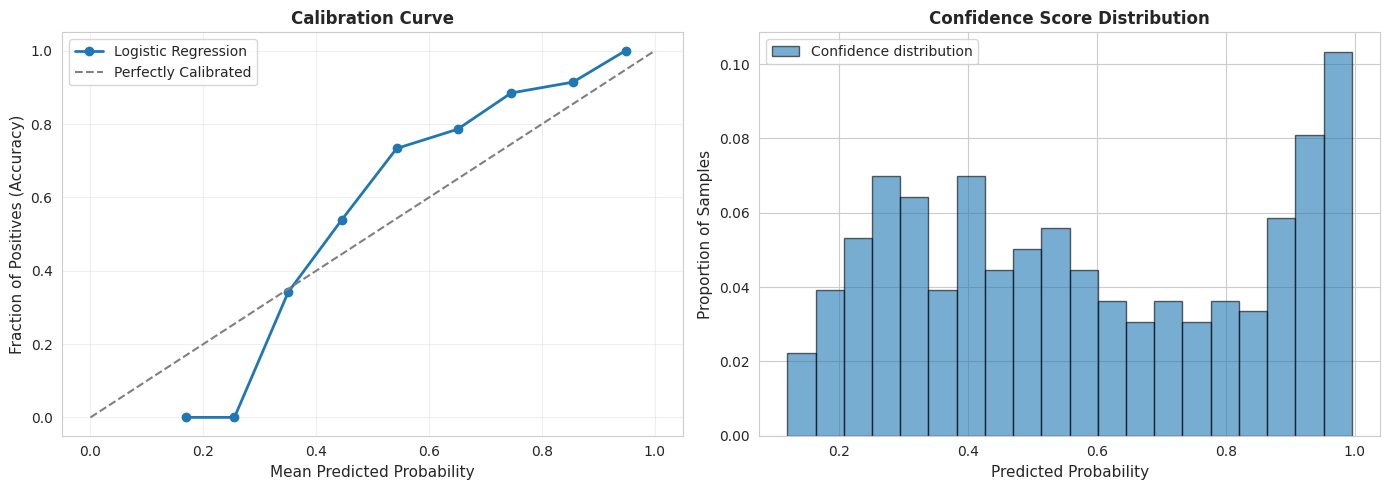

Expected Calibration Error (ECE): 0.1225
Lower ECE → better calibrated model (0 is perfect)


In [106]:
# Calibration Curve - Does predicted probability match actual accuracy?
from sklearn.calibration import calibration_curve

plt.figure(figsize=(14, 5))

# 1. Calibration curve
plt.subplot(1, 2, 1)
prob_true, prob_pred = calibration_curve(correct, confidence_scores, n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability', fontsize=11)
plt.ylabel('Fraction of Positives (Accuracy)', fontsize=11)
plt.title('Calibration Curve', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# 2. Reliability diagram with histogram
plt.subplot(1, 2, 2)
plt.hist(confidence_scores, bins=20, weights=np.ones(len(confidence_scores)) / len(confidence_scores),
         alpha=0.6, edgecolor='black', label='Confidence distribution')
plt.xlabel('Predicted Probability', fontsize=11)
plt.ylabel('Proportion of Samples', fontsize=11)
plt.title('Confidence Score Distribution', fontsize=12, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

# Expected Calibration Error (ECE)
ece = np.abs(prob_true - prob_pred).mean()
print(f"Expected Calibration Error (ECE): {ece:.4f}")
print(f"Lower ECE → better calibrated model (0 is perfect)")


In [107]:
# --- 6) Visualizations -------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)

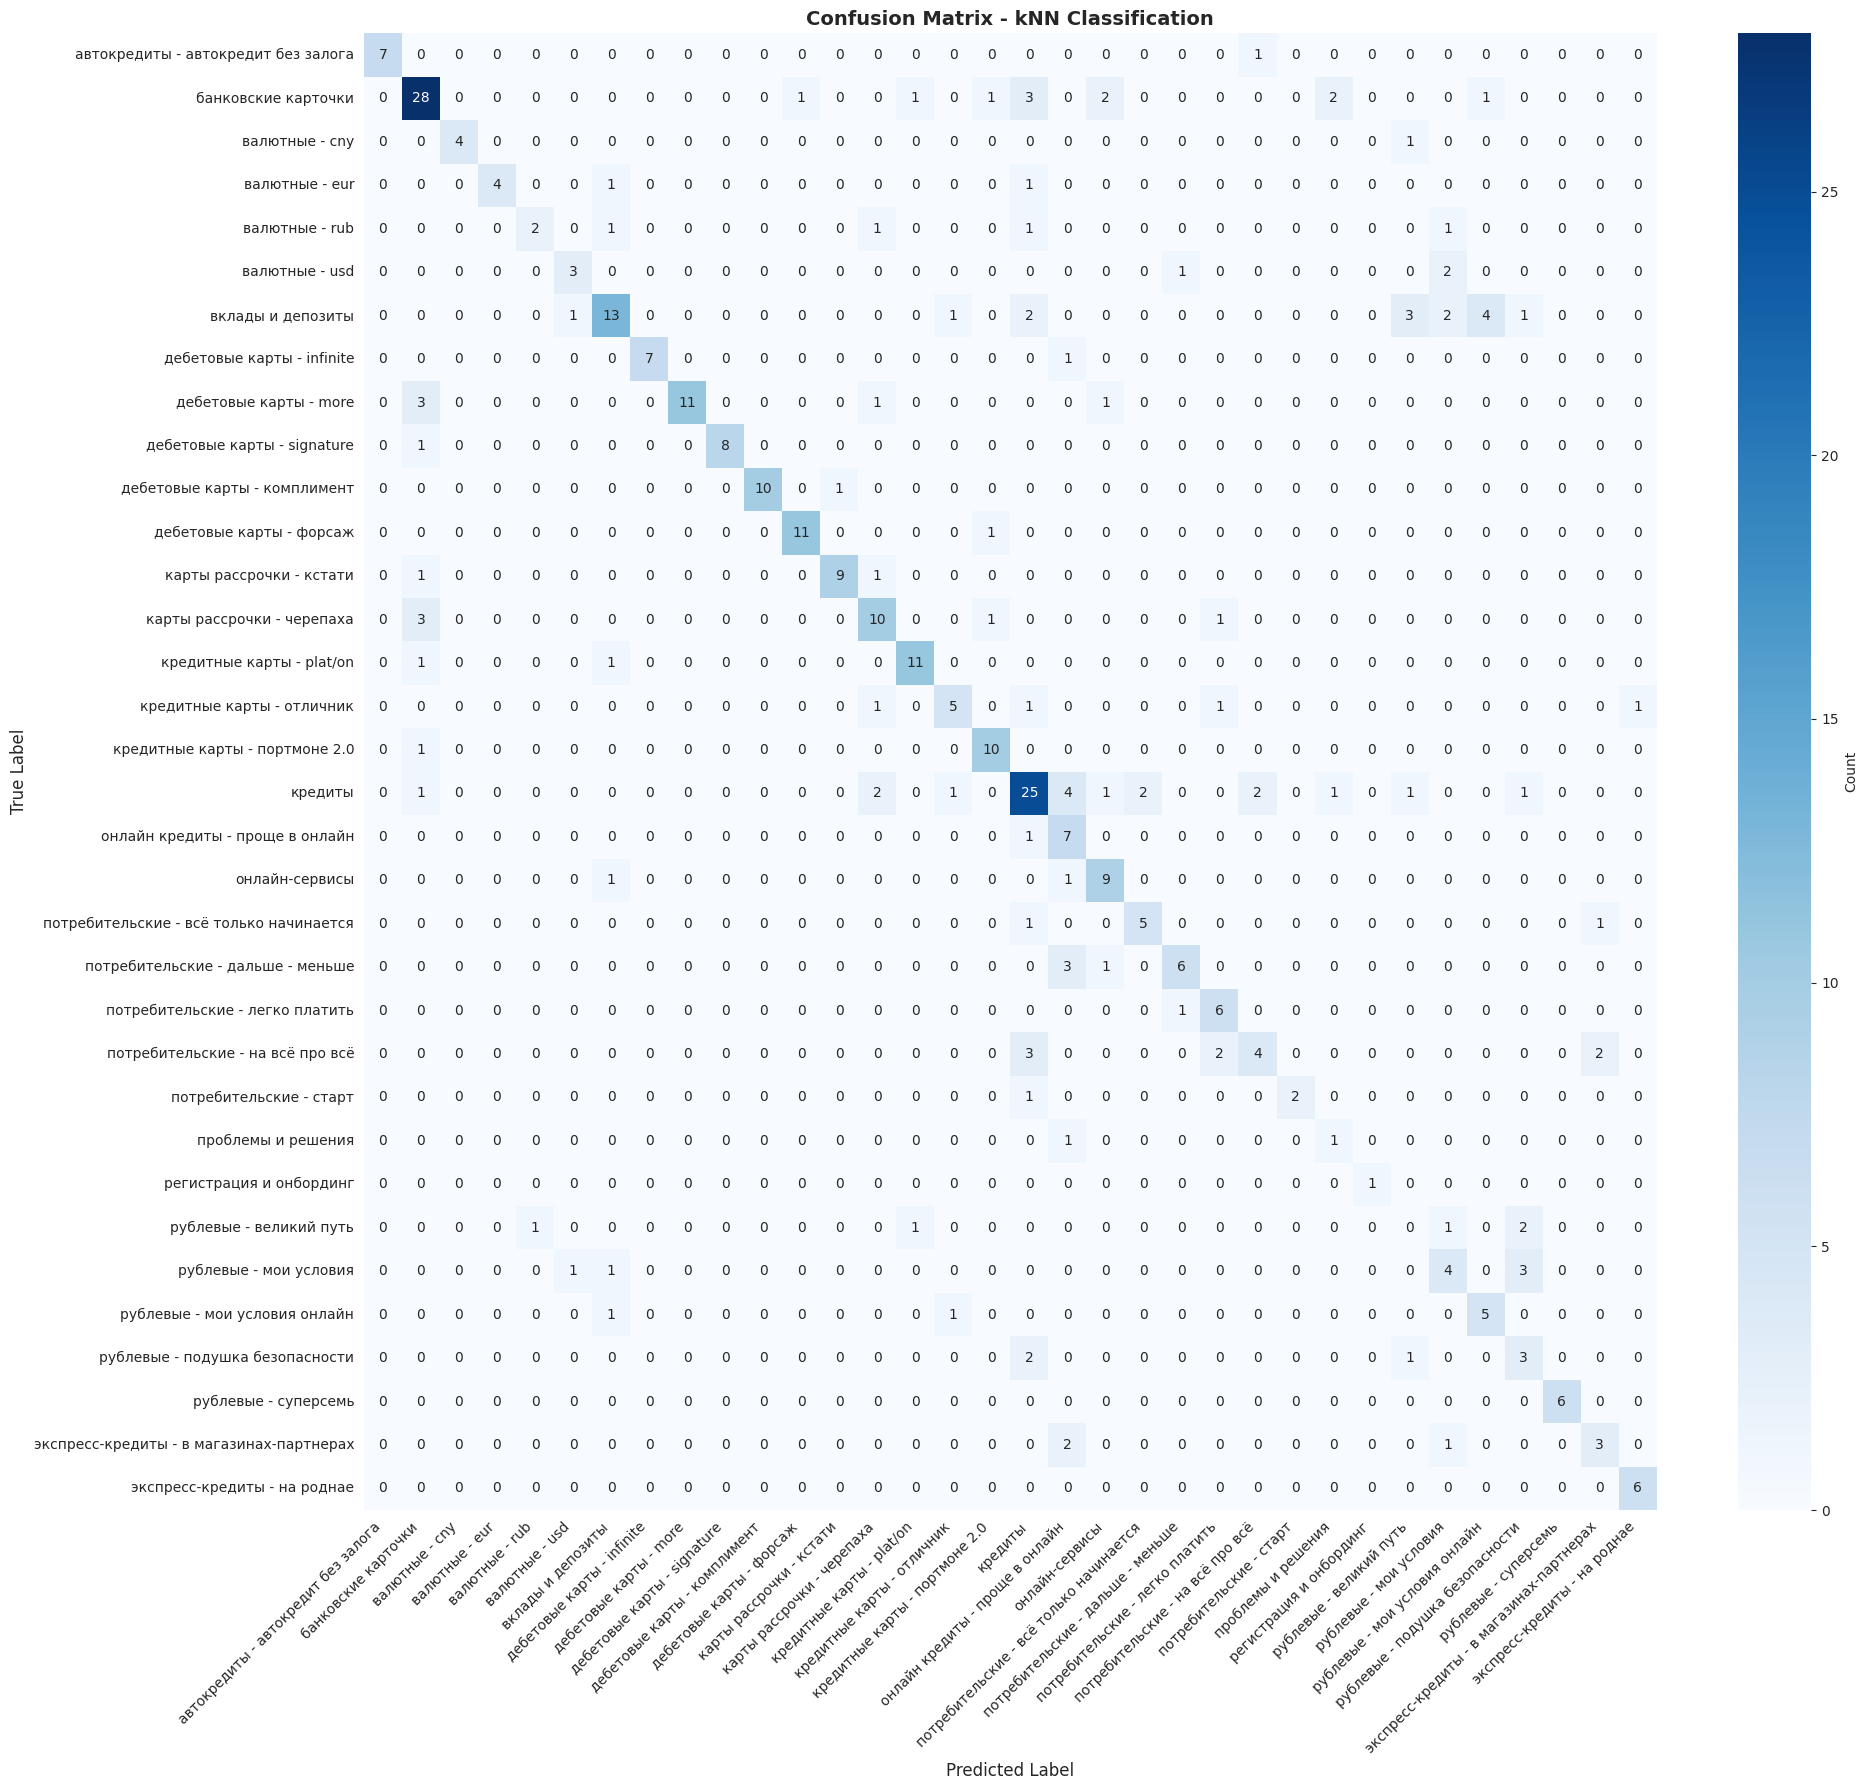

Total classes: 34
Total predictions: 358


In [108]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
unique_labels = sorted(list(set(y_true + y_pred)))

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - kNN Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"Total classes: {len(unique_labels)}")
print(f"Total predictions: {len(y_true)}")

In [27]:
# production_classifier_retrieval.py - Lean, surgical, based solution
"""
Philosophy: 
- Classification narrows search space (exploit 78% parent accuracy)
- Retrieval finds actual answer (exploit paraphrase nature of validation)
- Confidence gating prevents catastrophic errors
- Simple beats complex in hackathons
"""

import numpy as np
import json
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')


# ========== CONFIG ==========
MIN_CLASS_SUPPORT = 3  # Lower threshold - we can handle small classes via retrieval
PARENT_C = 5.0
CHILD_C = 2.0
ALPHA = 0.3  # Blend between data prototypes and description embeddings
CONFIDENCE_THRESHOLDS = (0.65, 0.50)  # (subcategory, parent) confidence gates


def l2(a: np.ndarray) -> np.ndarray:
    """L2 normalize vectors."""
    a = np.asarray(a)
    if a.ndim == 1:
        return a / (np.linalg.norm(a) + 1e-9)
    if a.ndim == 2:
        return a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-9)
    raise ValueError("l2() expects 1-D or 2-D array")


# ========== DATA LOADING ==========
print("="*80)
print("LOADING DATA")
print("="*80)

y, X = get_original_data()
y_aug, X_aug = get_augumented_data()

# Split original data first (sacred - never contaminate test with synthetic)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Add synthetic only to training (validation will be real paraphrases)
X_aug_train, _, y_aug_train, _ = train_test_split(
    X_aug, y_aug, test_size=0.3, random_state=42, stratify=y_aug
)

X_train = X_real_train + X_aug_train
y_train = y_real_train + y_aug_train
X_test = X_real_test  # Pure real data
y_test = y_real_test

print(f"Train: {len(X_train)} (real: {len(X_real_train)}, syn: {len(X_aug_train)})")
print(f"Test: {len(X_test)} (100% real - as it should be)")


# ========== TAXONOMY ==========
label_desc = pl.read_csv("label_desc.csv")
sub_names_tax = label_desc["subcategory"].map_elements(normalize_text).to_list()
cat_names_tax = label_desc["category"].map_elements(normalize_text).to_list()
label_texts = label_desc["generated_label"].map_elements(normalize_text).to_list()
sub2cat = {s: c for s, c in zip(sub_names_tax, cat_names_tax)}

# Clean toxic classes (low support)
class_counts = Counter(y_train)
toxic_classes = {cls for cls, cnt in class_counts.items() if cnt < MIN_CLASS_SUPPORT}

if toxic_classes:
    print(f"\n⚠️  Dropping {len(toxic_classes)} toxic classes: {sorted(toxic_classes)}")
    
    # Remove from train/test
    mask_train = np.array([y not in toxic_classes for y in y_train])
    X_train = [x for x, m in zip(X_train, mask_train) if m]
    y_train = [y for y, m in zip(y_train, mask_train) if m]
    
    mask_test = np.array([y not in toxic_classes for y in y_test])
    X_test = [x for x, m in zip(X_test, mask_test) if m]
    y_test = [y for y, m in zip(y_test, mask_test) if m]
    
    # Update taxonomy
    valid_indices = [i for i, s in enumerate(sub_names_tax) if s not in toxic_classes]
    sub_names_tax = [sub_names_tax[i] for i in valid_indices]
    cat_names_tax = [cat_names_tax[i] for i in valid_indices]
    label_texts = [label_texts[i] for i in valid_indices]
    sub2cat = {s: c for s, c in sub2cat.items() if s not in toxic_classes}

# Build mappings
sub2id = {name: i for i, name in enumerate(sub_names_tax)}
id2sub = {i: name for name, i in sub2id.items()}

cat2id = {}
id2cat = {}
for name in cat_names_tax:
    if name not in cat2id:
        cid = len(cat2id)
        cat2id[name] = cid
        id2cat[cid] = name

# Convert to IDs
y_sub_train = np.array([sub2id[s] for s in y_train], dtype=np.int32)
y_cat_train = np.array([cat2id[sub2cat[s]] for s in y_train], dtype=np.int32)
y_sub_test = np.array([sub2id[s] for s in y_test], dtype=np.int32)
y_cat_test = np.array([cat2id[sub2cat[s]] for s in y_test], dtype=np.int32)

parent_map = np.array([cat2id[c] for c in cat_names_tax], dtype=np.int32)
N_SUB = len(sub2id)
N_CAT = len(cat2id)

print(f"Taxonomy: {N_SUB} subcategories, {N_CAT} parent categories")


# ========== EMBEDDINGS ==========
X_train_emb = l2(np.array(X_train))
X_test_emb = l2(np.array(X_test))
desc_vecs = l2(get_embeddings_batch_local(label_texts))

print(f"Embeddings: train={X_train_emb.shape}, test={X_test_emb.shape}")


# ========== PROTOTYPES ==========
def build_prototypes(X_emb, y_sub, desc_vecs, alpha=ALPHA):
    """
    Build class prototypes by blending:
    - Empirical mean of training examples (1-alpha)
    - Label description embedding (alpha)
    
    Why: Handles classes with few samples + injects semantic prior.
    """
    protos = np.zeros((N_SUB, desc_vecs.shape[1]), dtype=np.float32)
    
    for i in range(N_SUB):
        idx = np.where(y_sub == i)[0]
        if len(idx) > 0:
            empirical_mean = X_emb[idx].mean(0)
            protos[i] = l2((1 - alpha) * empirical_mean + alpha * desc_vecs[i])
        else:
            # No training examples - fall back to description
            protos[i] = desc_vecs[i]
    
    return protos

protos = build_prototypes(X_train_emb, y_sub_train, desc_vecs)


# ========== HIERARCHICAL CLASSIFIER (SURGICAL VERSION) ==========
class LeanHierarchicalClassifier:
    """
    Two-stage classifier:
    1. Parent category (exploits high parent accuracy)
    2. Child subcategory within parent (avoids cross-category confusion)
    
    Key insight: 78% parent accuracy → narrow search space → better child prediction
    """
    def __init__(self, parent_C=5.0, child_C=2.0):
        self.parent_C = parent_C
        self.child_C = child_C
        self.parent_clf = None
        self.protos = None
    
    def fit(self, X_emb, y_sub, y_cat, protos):
        """Train parent classifier only. Child uses prototypes (no overfitting)."""
        self.protos = protos
        
        # Parent classifier: simple LR on embeddings (no feature engineering needed)
        self.parent_clf = LogisticRegression(
            C=self.parent_C,
            max_iter=2000,
            class_weight='balanced',  # Handle class imbalance
            random_state=42
        )
        self.parent_clf.fit(X_emb, y_cat)
        
        print(f"✅ Trained parent classifier ({N_CAT} classes)")
    
    def predict(self, X_emb):
        """Hierarchical prediction: parent → child."""
        if X_emb.ndim == 1:
            X_emb = X_emb.reshape(1, -1)
        
        # Predict parent
        parent_preds = self.parent_clf.predict(X_emb)
        
        y_pred = np.zeros(len(X_emb), dtype=np.int32)
        
        for i, parent_id in enumerate(parent_preds):
            # Get children in this parent
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if len(child_ids) == 1:
                # Only one child - deterministic
                y_pred[i] = child_ids[0]
            else:
                # Multiple children - use prototype similarity
                child_sims = self.protos[child_ids] @ X_emb[i]
                y_pred[i] = child_ids[child_sims.argmax()]
        
        return y_pred
    
    def predict_proba(self, X_emb):
        """Return parent probabilities (used for confidence gating)."""
        if X_emb.ndim == 1:
            X_emb = X_emb.reshape(1, -1)
        return self.parent_clf.predict_proba(X_emb)
    
    def predict_with_meta(self, X_emb):
        """
        Return predictions + metadata for retrieval system.
        
        Returns: list of dicts with:
        - parent_id, parent_name, parent_confidence
        - child_id, child_name, child_confidence
        - top3_children (for fallback retrieval)
        """
        if X_emb.ndim == 1:
            X_emb = X_emb.reshape(1, -1)
        
        parent_probs = self.parent_clf.predict_proba(X_emb)
        parent_preds = parent_probs.argmax(1)
        parent_confs = parent_probs.max(1)
        
        results = []
        for i, (x, parent_id, parent_conf) in enumerate(zip(X_emb, parent_preds, parent_confs)):
            child_mask = parent_map == parent_id
            child_ids = np.where(child_mask)[0]
            
            if len(child_ids) == 1:
                child_id = child_ids[0]
                child_conf = 1.0
                top3_children = [child_id]
            else:
                child_sims = self.protos[child_ids] @ x
                sorted_indices = child_sims.argsort()[::-1]
                
                child_id = child_ids[sorted_indices[0]]
                child_conf = child_sims[sorted_indices[0]]  # Cosine similarity as confidence
                top3_children = child_ids[sorted_indices[:min(3, len(child_ids))]]
            
            results.append({
                'parent_id': int(parent_id),
                'parent_name': id2cat[parent_id],
                'parent_confidence': float(parent_conf),
                'child_id': int(child_id),
                'child_name': id2sub[child_id],
                'child_confidence': float(child_conf),
                'top3_children': [int(c) for c in top3_children]
            })
        
        return results


# ========== TRAIN CLASSIFIER ==========
print("\n" + "="*80)
print("TRAINING LEAN CLASSIFIER")
print("="*80)

clf = LeanHierarchicalClassifier(parent_C=PARENT_C, child_C=CHILD_C)
clf.fit(X_train_emb, y_sub_train, y_cat_train, protos)

# Evaluate
y_pred = clf.predict(X_test_emb)
acc = accuracy_score(y_sub_test, y_pred)
f1_macro = f1_score(y_sub_test, y_pred, average='macro', zero_division=0)

parent_pred = np.array([parent_map[p] for p in y_pred])
parent_true = np.array([parent_map[t] for t in y_sub_test])
parent_acc = accuracy_score(parent_true, parent_pred)

print(f"\n📊 Classification Results:")
print(f"  Subcategory Accuracy: {acc:.3f}")
print(f"  Parent Accuracy:      {parent_acc:.3f} ⭐")
print(f"  Macro F1:             {f1_macro:.3f}")


# ========== CATEGORY-CONSTRAINED RETRIEVAL SYSTEM ==========
class CategoryConstrainedRetriever:
    """
    Adaptive retrieval based on classification confidence:
    
    HIGH confidence (>0.65) → search within predicted subcategory
    MEDIUM confidence (>0.50) → search within parent category
    LOW confidence (<0.50) → search globally (all training data)
    
    Why this works:
    - Exploits 78% parent accuracy to narrow search space
    - Falls back gracefully when uncertain
    - Avoids catastrophic errors from wrong classification
    """
    def __init__(self, classifier, parent_map, train_data, conf_thresholds=(0.65, 0.50)):
        """
        Args:
            classifier: LeanHierarchicalClassifier instance
            parent_map: np.array mapping subcat_id → parent_id
            train_data: list of tuples (question_text, subcat_id, emb, template_text)
            conf_thresholds: (subcat_threshold, parent_threshold)
        """
        self.clf = classifier
        self.parent_map = parent_map
        self.subcat_thresh, self.parent_thresh = conf_thresholds
        
        # Build indices for fast retrieval
        print("Building retrieval indices...")
        
        # Index by subcategory
        self.subcat_index = defaultdict(lambda: {'embs': [], 'data': []})
        # Index by parent category  
        self.parent_index = defaultdict(lambda: {'embs': [], 'data': []})
        # Global index
        self.global_embs = []
        self.global_data = []
        
        for question, subcat_id, emb, template in train_data:
            parent_id = parent_map[subcat_id]
            entry = (question, template, subcat_id, parent_id)
            
            self.subcat_index[subcat_id]['embs'].append(emb)
            self.subcat_index[subcat_id]['data'].append(entry)
            
            self.parent_index[parent_id]['embs'].append(emb)
            self.parent_index[parent_id]['data'].append(entry)
            
            self.global_embs.append(emb)
            self.global_data.append(entry)
        
        # Convert to numpy for vectorized cosine similarity
        for subcat_id in self.subcat_index:
            self.subcat_index[subcat_id]['embs'] = np.array(
                self.subcat_index[subcat_id]['embs']
            )
        
        for parent_id in self.parent_index:
            self.parent_index[parent_id]['embs'] = np.array(
                self.parent_index[parent_id]['embs']
            )
        
        self.global_embs = np.array(self.global_embs)
        
        print(f"✅ Indexed {len(self.global_data)} training examples")
        print(f"   - {len(self.subcat_index)} subcategories")
        print(f"   - {len(self.parent_index)} parent categories")
    
    def retrieve(self, query_text, top_k=1, return_metadata=False):
        """
        Main retrieval function.
        
        Returns:
            If top_k=1: single result dict
            If top_k>1: list of result dicts
            
        Result dict contains:
            - template: the answer template text
            - matched_question: training question that was matched
            - similarity: cosine similarity score
            - search_scope: 'subcategory' | 'parent' | 'global'
            - confidence: classification confidence
            - (optional) full classification metadata
        """
        # Get embedding
        query_emb = l2(get_embeddings_batch_local([query_text])[0])
        
        # Get classification prediction + confidence
        meta = self.clf.predict_with_meta(query_emb.reshape(1, -1))[0]
        
        parent_conf = meta['parent_confidence']
        child_conf = meta['child_confidence']
        
        # Decide search scope based on confidence
        if child_conf > self.subcat_thresh:
            # HIGH confidence → search within subcategory
            scope = 'subcategory'
            search_id = meta['child_id']
            
            if search_id in self.subcat_index:
                candidate_embs = self.subcat_index[search_id]['embs']
                candidate_data = self.subcat_index[search_id]['data']
            else:
                # Fallback if no training examples in this subcat
                scope = 'parent'
                search_id = meta['parent_id']
                candidate_embs = self.parent_index[search_id]['embs']
                candidate_data = self.parent_index[search_id]['data']
        
        elif parent_conf > self.parent_thresh:
            # MEDIUM confidence → search within parent category
            scope = 'parent'
            search_id = meta['parent_id']
            candidate_embs = self.parent_index[search_id]['embs']
            candidate_data = self.parent_index[search_id]['data']
        
        else:
            # LOW confidence → global search
            scope = 'global'
            search_id = None
            candidate_embs = self.global_embs
            candidate_data = self.global_data
        
        # Compute similarities and retrieve top-k
        similarities = candidate_embs @ query_emb
        top_indices = similarities.argsort()[-top_k:][::-1]
        
        results = []
        for idx in top_indices:
            question, template, subcat_id, parent_id = candidate_data[idx]
            
            result = {
                'template': template,
                'matched_question': question,
                'similarity': float(similarities[idx]),
                'search_scope': scope,
                'num_candidates': len(candidate_data),
                'confidence': {
                    'parent': parent_conf,
                    'child': child_conf
                }
            }
            
            if return_metadata:
                result['classification'] = meta
                result['matched_subcat'] = id2sub[subcat_id]
                result['matched_parent'] = id2cat[parent_id]
            
            results.append(result)
        
        return results[0] if top_k == 1 else results
    
    def evaluate(self, X_test, y_test_questions, y_test_templates, verbose=True):
        """
        Evaluate retrieval accuracy on test set.
        
        Metrics:
        - Top-1 accuracy: % of times correct template is retrieved
        - Search scope distribution: how often each scope is used
        - Accuracy by scope: performance breakdown
        """
        correct = 0
        scope_counts = Counter()
        scope_correct = defaultdict(int)
        
        for i, (x, true_q, true_template) in enumerate(zip(X_test, y_test_questions, y_test_templates)):
            result = self.retrieve(true_q, top_k=1)
            
            retrieved_template = result['template']
            scope = result['search_scope']
            
            scope_counts[scope] += 1
            
            if retrieved_template == true_template:
                correct += 1
                scope_correct[scope] += 1
        
        accuracy = correct / len(X_test)
        
        if verbose:
            print(f"\n📊 Retrieval Results:")
            print(f"  Top-1 Template Accuracy: {accuracy:.3f} ({correct}/{len(X_test)})")
            print(f"\n  Search Scope Distribution:")
            for scope in ['subcategory', 'parent', 'global']:
                count = scope_counts[scope]
                if count > 0:
                    scope_acc = scope_correct[scope] / count
                    print(f"    {scope:12s}: {count:3d} queries ({count/len(X_test)*100:5.1f}%) "
                          f"→ {scope_acc:.3f} accuracy")
        
        return {
            'accuracy': accuracy,
            'scope_counts': dict(scope_counts),
            'scope_accuracy': {s: scope_correct[s]/scope_counts[s] 
                              for s in scope_counts if scope_counts[s] > 0}
        }


# ========== BUILD RETRIEVAL SYSTEM ==========
print("\n" + "="*80)
print("BUILDING RETRIEVAL SYSTEM")
print("="*80)

# Prepare training data for retrieval index
# (question_text, subcat_id, embedding, template_text)
train_data = [
    (y_train[i], y_sub_train[i], X_train_emb[i], y_train[i])  
    # NOTE: Using y_train[i] as both question and template
    # In your actual code, load separate template texts
    for i in range(len(X_train))
]

retriever = CategoryConstrainedRetriever(
    classifier=clf,
    parent_map=parent_map,
    train_data=train_data,
    conf_thresholds=CONFIDENCE_THRESHOLDS
)


# ========== EVALUATE RETRIEVAL ==========
print("\n" + "="*80)
print("EVALUATING END-TO-END SYSTEM")
print("="*80)

# For evaluation, assume test questions have corresponding templates
# In production, y_test contains question texts, templates are retrieved
retrieval_results = retriever.evaluate(
    X_test_emb,
    y_test_questions=y_test,  # Test question texts
    y_test_templates=y_test,  # True template texts (for evaluation)
    verbose=True
)


# ========== DEMO ==========
print("\n" + "="*80)
print("DEMO: Query → Template Retrieval")
print("="*80)

demo_queries = [
    "хочу взять кредит на машину",
    "какие условия по вкладам?",
    "не могу войти в приложение",
    "нужна карта для студента",
    "открыть рублевый депозит"
]

for query in demo_queries:
    result = retriever.retrieve(query, return_metadata=True)
    
    print(f"\n{'='*60}")
    print(f"Query: {query}")
    print(f"{'='*60}")
    print(f"Template: {result['template'][:100]}...")
    print(f"Matched:  {result['matched_question'][:100]}...")
    print(f"Similarity: {result['similarity']:.3f}")
    print(f"Scope: {result['search_scope']} ({result['num_candidates']} candidates)")
    print(f"Confidence: parent={result['confidence']['parent']:.3f}, "
          f"child={result['confidence']['child']:.3f}")
    print(f"Classification: {result['classification']['parent_name']} → "
          f"{result['classification']['child_name']}")


# ========== SAVE PRODUCTION MODEL ==========
import pickle

production_model = {
    'classifier': clf,
    'retriever': retriever,
    'protos': protos,
    'mappings': {
        'sub2id': sub2id,
        'id2sub': id2sub,
        'cat2id': cat2id,
        'id2cat': id2cat,
        'parent_map': parent_map,
        'sub2cat': sub2cat
    },
    'config': {
        'parent_C': PARENT_C,
        'child_C': CHILD_C,
        'alpha': ALPHA,
        'conf_thresholds': CONFIDENCE_THRESHOLDS
    }
}

with open('production_classifier_retriever.pkl', 'wb') as f:
    pickle.dump(production_model, f)

print("\n✅ Production model saved to production_classifier_retriever.pkl")


# ========== PRODUCTION INFERENCE API ==========
def inference_api(query_text, top_k=3):
    """
    Clean API for production deployment.
    
    Args:
        query_text: User question
        top_k: Number of templates to return
    
    Returns:
        {
            'top_templates': [
                {
                    'template': str,
                    'confidence': float,
                    'matched_question': str
                },
                ...
            ],
            'classification': {
                'parent': str,
                'child': str,
                'confidence': float
            },
            'debug': {
                'search_scope': str,
                'num_candidates': int
            }
        }
    """
    results = retriever.retrieve(query_text, top_k=top_k, return_metadata=True)
    
    if top_k == 1:
        results = [results]
    
    return {
        'top_templates': [
            {
                'template': r['template'],
                'confidence': r['similarity'],
                'matched_question': r['matched_question']
            }
            for r in results
        ],
        'classification': {
            'parent': results[0]['classification']['parent_name'],
            'child': results[0]['classification']['child_name'],
            'confidence': results[0]['confidence']['parent']
        },
        'debug': {
            'search_scope': results[0]['search_scope'],
            'num_candidates': results[0]['num_candidates']
        }
    }


print("\n" + "="*80)
print("PRODUCTION API READY")
print("="*80)
print("Usage:")
print("  response = inference_api('хочу взять кредит', top_k=3)")
print("  print(response['top_templates'][0]['template'])")


LOADING DATA
Augmented data size: 1054
Train: 897 (real: 160, syn: 737)
Test: 41 (100% real - as it should be)

⚠️  Dropping 2 toxic classes: ['первые шаги', 'регистрация и онбординг']
Taxonomy: 33 subcategories, 5 parent categories
Embeddings: train=(893, 1024), test=(40, 1024)

TRAINING LEAN CLASSIFIER
Augmented data size: 1054
Train: 897 (real: 160, syn: 737)
Test: 41 (100% real - as it should be)

⚠️  Dropping 2 toxic classes: ['первые шаги', 'регистрация и онбординг']
Taxonomy: 33 subcategories, 5 parent categories
Embeddings: train=(893, 1024), test=(40, 1024)

TRAINING LEAN CLASSIFIER
✅ Trained parent classifier (5 classes)

📊 Classification Results:
  Subcategory Accuracy: 0.850
  Parent Accuracy:      0.850 ⭐
  Macro F1:             0.813

BUILDING RETRIEVAL SYSTEM
Building retrieval indices...
✅ Indexed 893 training examples
   - 33 subcategories
   - 5 parent categories

EVALUATING END-TO-END SYSTEM
✅ Trained parent classifier (5 classes)

📊 Classification Results:
  Subcate

LOADING DATA
Augmented data size: 1054
Train: 897 (real: 160, syn: 737)
Test: 41 (100% real - as it should be)

⚠️  Dropping 2 toxic classes: ['первые шаги', 'регистрация и онбординг']
Taxonomy: 33 subcategories, 5 parent categories
Embeddings: train=(893, 1024), test=(40, 1024)

TRAINING LEAN CLASSIFIER
Augmented data size: 1054
Train: 897 (real: 160, syn: 737)
Test: 41 (100% real - as it should be)

⚠️  Dropping 2 toxic classes: ['первые шаги', 'регистрация и онбординг']
Taxonomy: 33 subcategories, 5 parent categories
Embeddings: train=(893, 1024), test=(40, 1024)

TRAINING LEAN CLASSIFIER
✅ Trained parent classifier (5 classes)

📊 Classification Results:
  Subcategory Accuracy: 0.850
  Parent Accuracy:      0.850 ⭐
  Macro F1:             0.813

BUILDING RETRIEVAL SYSTEM
Building retrieval indices...
✅ Indexed 893 training examples
   - 33 subcategories
   - 5 parent categories

EVALUATING END-TO-END SYSTEM
✅ Trained parent classifier (5 classes)

📊 Classification Results:
  Subcate

AttributeError: Can't get local object 'CategoryConstrainedRetriever.__init__.<locals>.<lambda>'

In [109]:
# Per-class Performance Analysis
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, 
                                                                   labels=unique_labels,
                                                                   zero_division=0)

# Create a dataframe for easier visualization
performance_df = pd.DataFrame({
    'Class': unique_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score', ascending=False)

print("Top 10 best performing classes:")
print(performance_df.head(10).to_string(index=False))
print("\n" + "="*80 + "\n")
print("Top 10 worst performing classes:")
print(performance_df.tail(10).to_string(index=False))

Top 10 best performing classes:
                              Class  Precision   Recall  F1-Score  Support
               рублевые - суперсемь   1.000000 1.000000  1.000000        6
            регистрация и онбординг   1.000000 1.000000  1.000000        1
       дебетовые карты - комплимент   1.000000 0.909091  0.952381       11
        дебетовые карты - signature   1.000000 0.888889  0.941176        9
         дебетовые карты - infinite   1.000000 0.875000  0.933333        8
автокредиты - автокредит без залога   1.000000 0.875000  0.933333        8
       экспресс-кредиты - на роднае   0.857143 1.000000  0.923077        6
           дебетовые карты - форсаж   0.916667 0.916667  0.916667       12
                     валютные - cny   1.000000 0.800000  0.888889        5
           карты рассрочки - кстати   0.900000 0.818182  0.857143       11


Top 10 worst performing classes:
                                   Class  Precision   Recall  F1-Score  Support
                       вклад

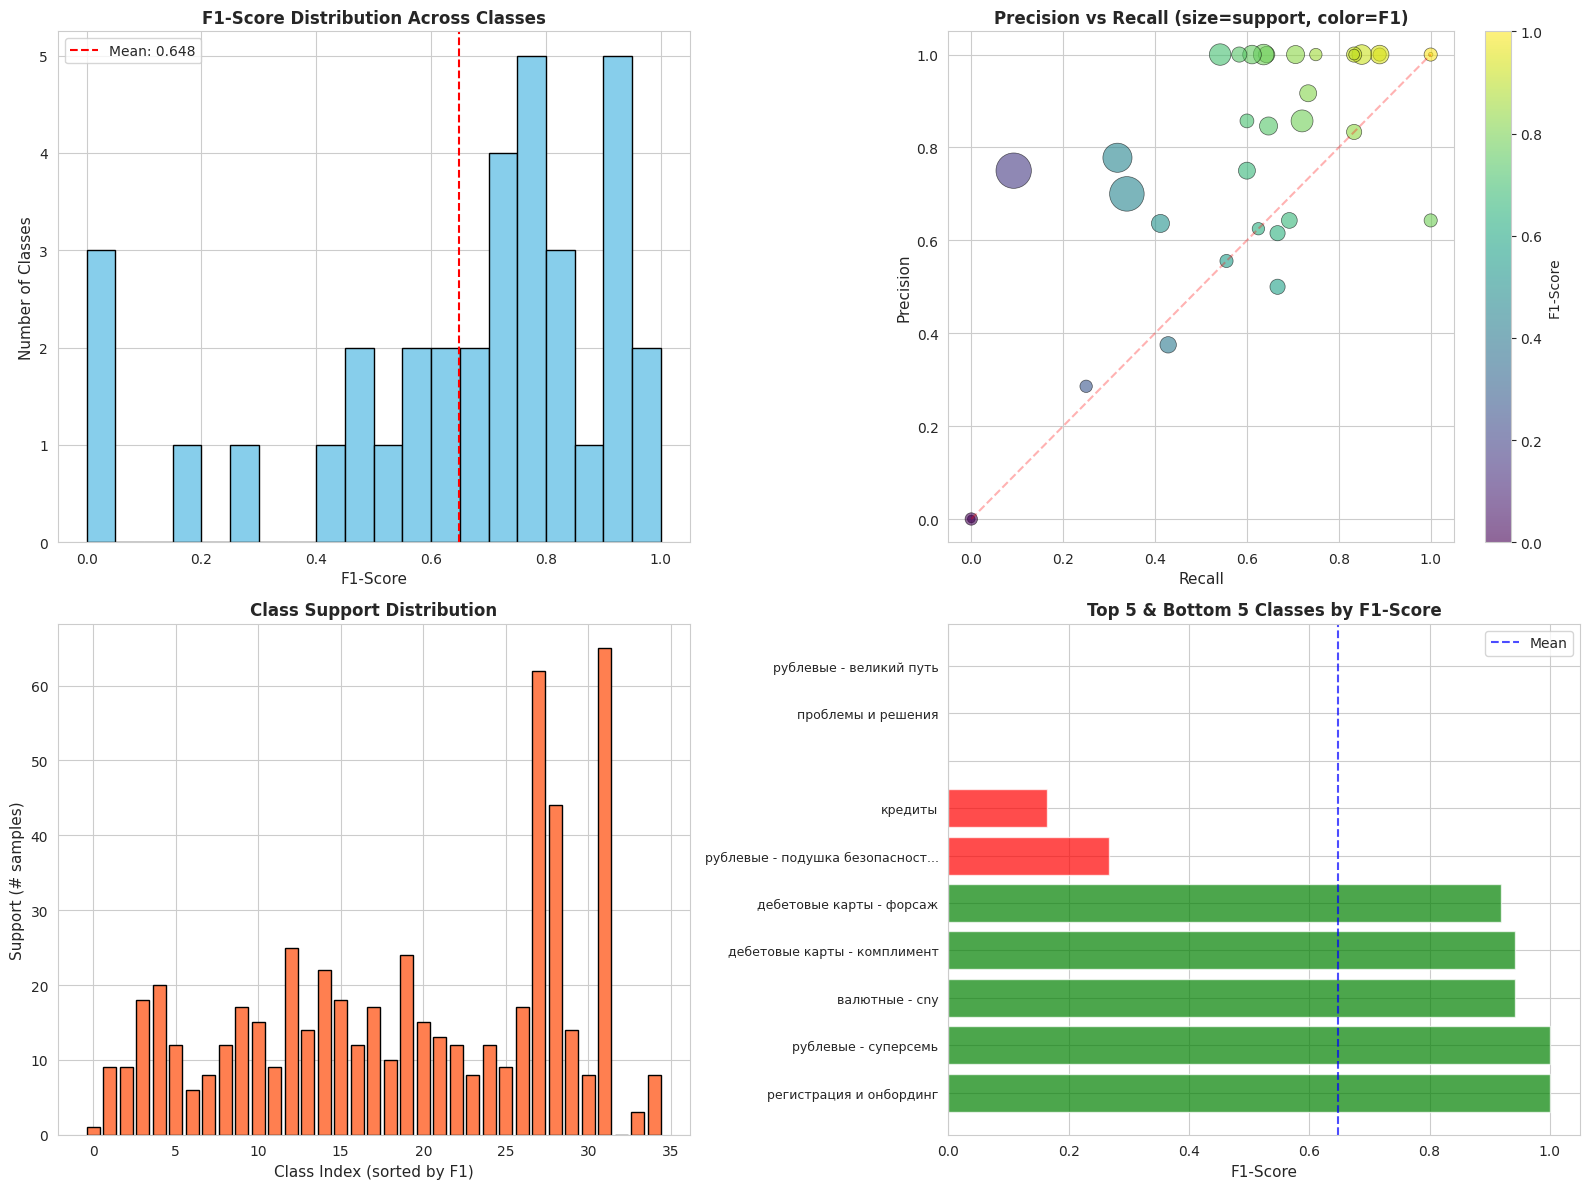

In [82]:
# Visualize per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score distribution
axes[0, 0].hist(performance_df['F1-Score'], bins=20, edgecolor='black', color='skyblue')
axes[0, 0].set_xlabel('F1-Score', fontsize=11)
axes[0, 0].set_ylabel('Number of Classes', fontsize=11)
axes[0, 0].set_title('F1-Score Distribution Across Classes', fontsize=12, fontweight='bold')
axes[0, 0].axvline(performance_df['F1-Score'].mean(), color='red', linestyle='--', 
                    label=f'Mean: {performance_df["F1-Score"].mean():.3f}')
axes[0, 0].legend()

# Precision vs Recall scatter
scatter = axes[0, 1].scatter(performance_df['Recall'], performance_df['Precision'], 
                             s=performance_df['Support']*10, alpha=0.6, c=performance_df['F1-Score'],
                             cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision vs Recall (size=support, color=F1)', fontsize=12, fontweight='bold')
axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='F1-Score')

# Support distribution
axes[1, 0].bar(range(len(performance_df)), performance_df['Support'].values, 
               color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Class Index (sorted by F1)', fontsize=11)
axes[1, 0].set_ylabel('Support (# samples)', fontsize=11)
axes[1, 0].set_title('Class Support Distribution', fontsize=12, fontweight='bold')

# Top/Bottom performers comparison
top_bottom = pd.concat([performance_df.head(5), performance_df.tail(5)])
x_pos = range(len(top_bottom))
axes[1, 1].barh(x_pos, top_bottom['F1-Score'], color=['green']*5 + ['red']*5, alpha=0.7)
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels([c[:30] + '...' if len(c) > 30 else c for c in top_bottom['Class']], 
                            fontsize=9)
axes[1, 1].set_xlabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Top 5 & Bottom 5 Classes by F1-Score', fontsize=12, fontweight='bold')
axes[1, 1].axvline(performance_df['F1-Score'].mean(), color='blue', linestyle='--', 
                    label='Mean', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_350305/4105298472.py:2: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


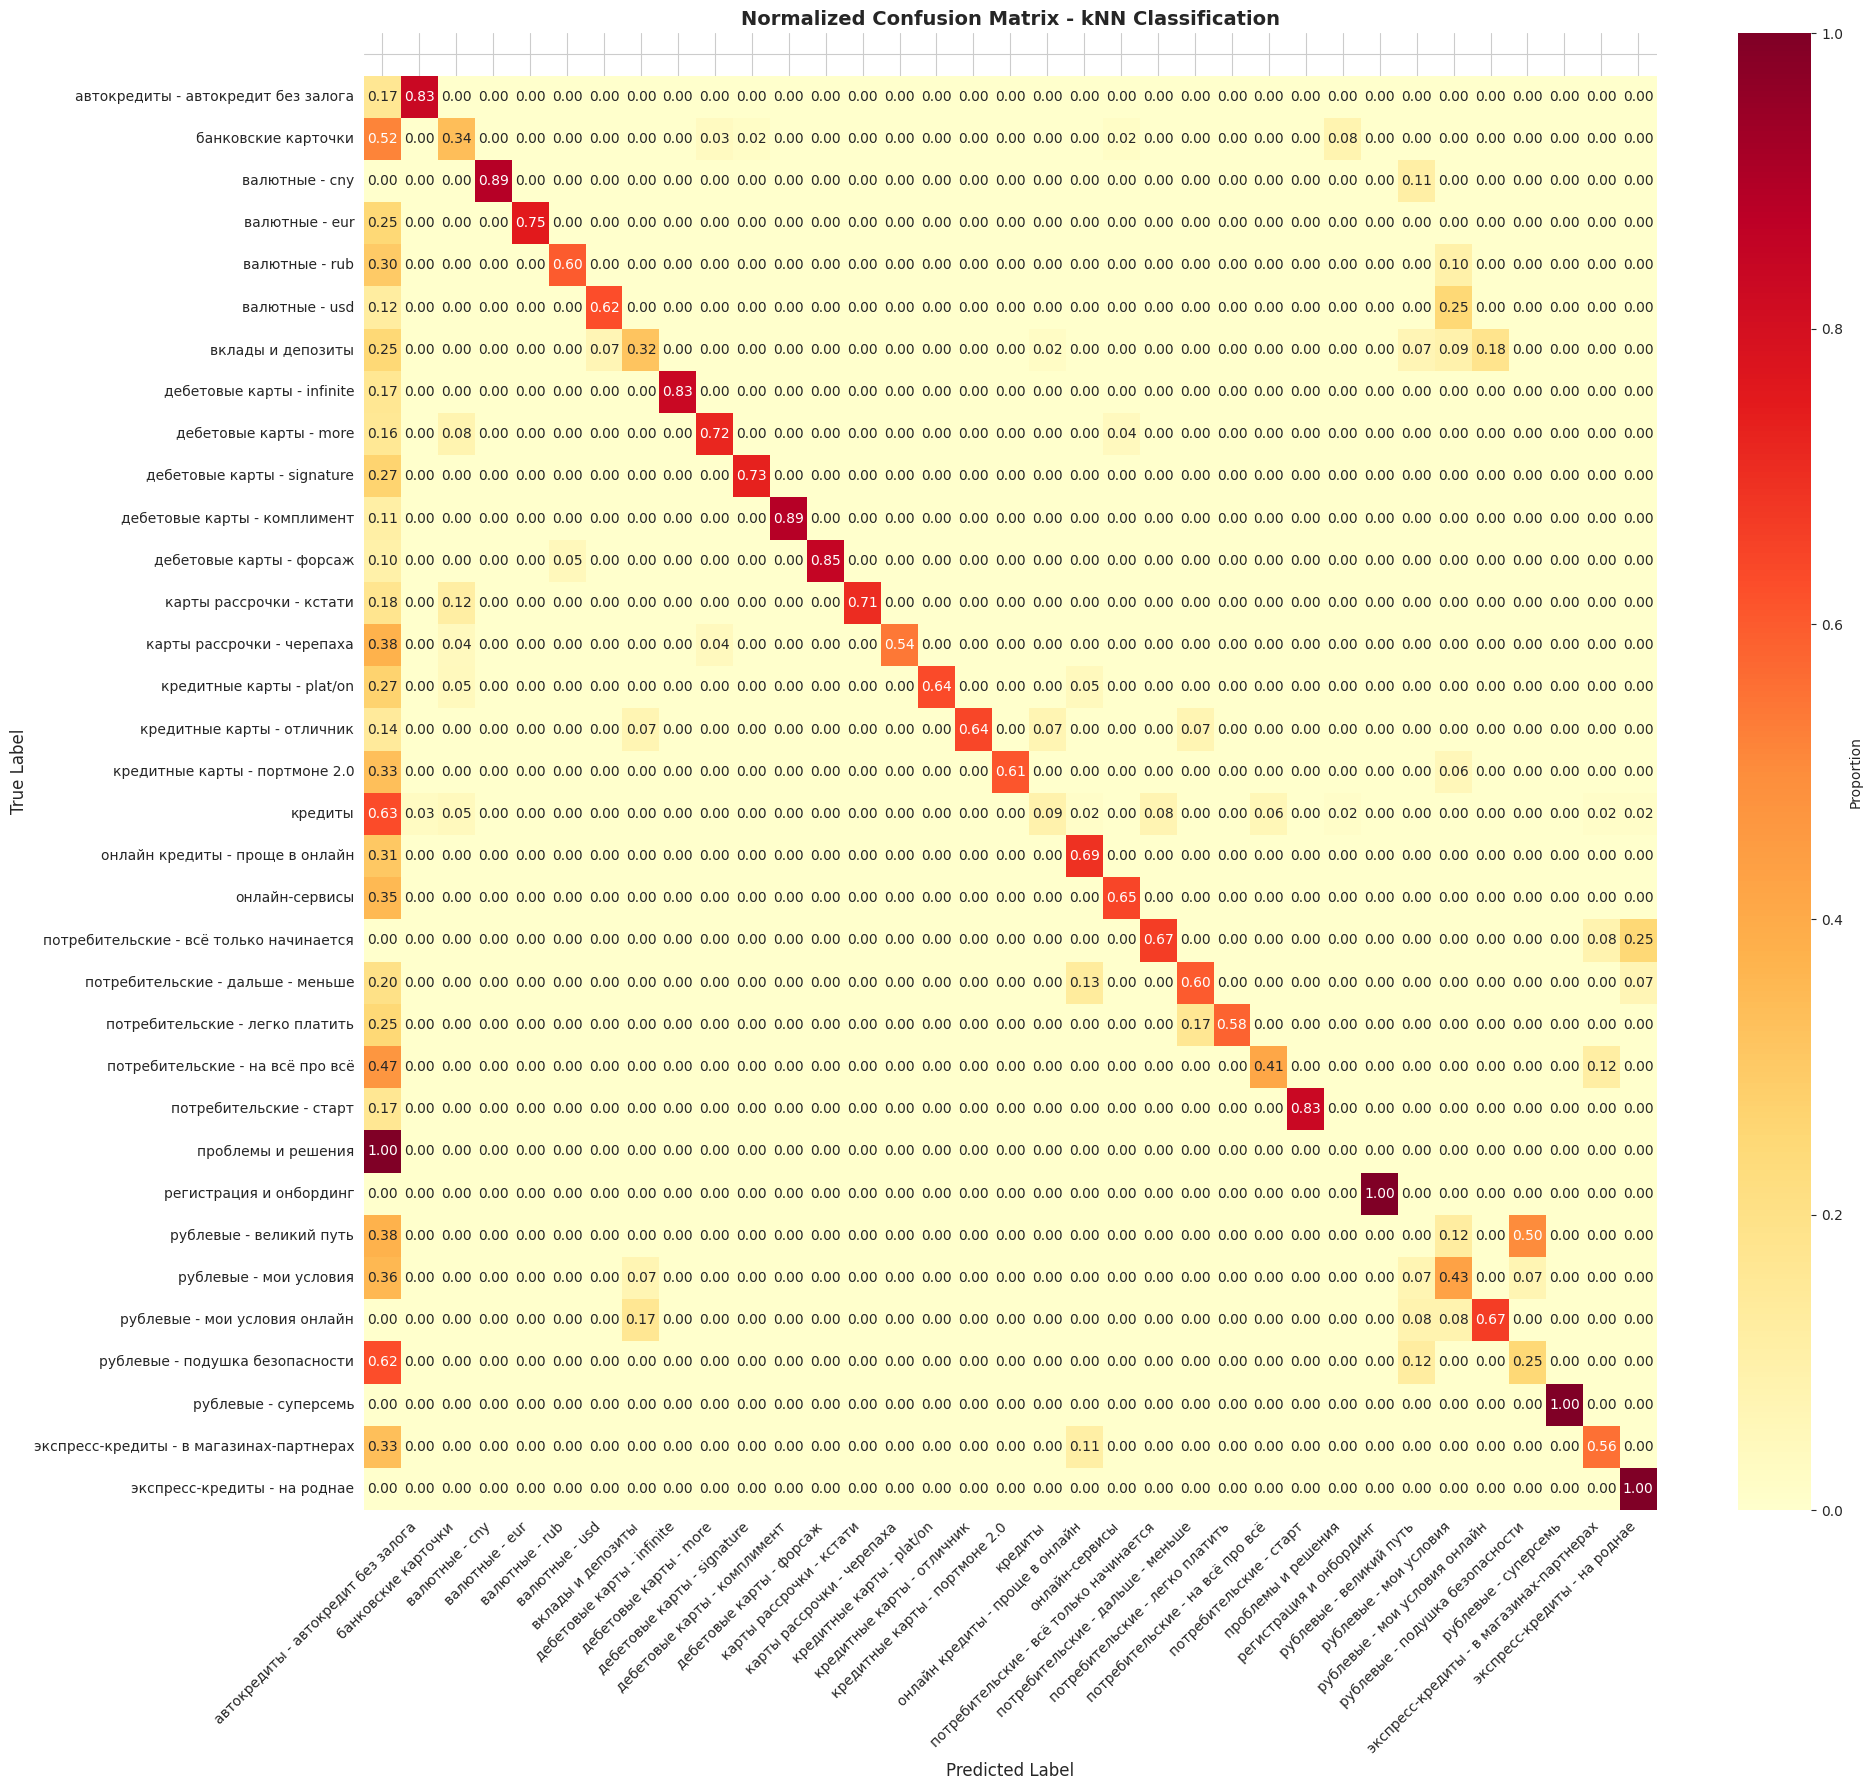

In [83]:
# Normalized Confusion Matrix (showing proportions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=unique_labels, yticklabels=unique_labels,
            cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix - kNN Classification', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [65]:
import pandas as pd
from openai import OpenAI
import json
import time
json_name = "added_data_qwen.json"
df = pd.read_csv("./data.csv", sep=";")
with open(json_name, 'r', encoding="utf-8") as file:
    loaded_data = json.load(file)

client = OpenAI(
    api_key="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",
    base_url="https://openrouter.ai/api/v1"
)


system_prompt = "Ты являешься новым клиентом банка. Тебе дано утверждение. Придумай 3-7 вопросов, на которые отвечает данное утверждение. За каждый корректный и уникальный вопрос ты получишь 100$. Вопрос не является корректным если в утверждении нет однозначного ответа, или вопрос слишком конкретный, или если вопрос слишком неестественный. В случае неккорекного вопроса с твоего счета будет вычтено 1000$.В ответе дожны быть ТОЛЬКО ВОПРОСЫ, разделенные переходом на новую линию, ничего более. Вопрос должен звучать естественно, как обычно реально задают вопрос клиенты, со всеми неточностями. Вопрос не должен быть слишком конкретный, потому что реально так не обащются."
for index, value in df.iterrows():
    if value["answer_pattern"] in loaded_data:
        continue
    print(value["answer_pattern"])

    response = client.chat.completions.create(
        model="qwen/qwen3-235b-a22b:free",
        messages=[
            {"role": "system", "content": f"{system_prompt}"},
            {
                "role": "user",
                "content": f"Категория утверждения - {value["category"]}, подкатегория - {value['subcategory']}, утверждение - {value['answer_pattern']}, пример вопроса к утверждению - {value['text']}",
            }
        ]
    )

    print(response.choices[0].message)
    loaded_data[value["answer_pattern"]] = response.choices[0].message.content.split("\n")

    with open(json_name, 'w', encoding="utf-8") as file:
        json.dump(loaded_data, file, indent = 4, ensure_ascii=False)
    
    time.sleep(1)

Карточку PLAT/ON можно оформить в интернет-банке или М-банкинге, в том числе виртуальную карточку, а также обратившись в любой офис Банка.


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-day. Add 10 credits to unlock 1000 free model requests per day', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '50', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1760572800000'}, 'provider_name': None}}, 'user_id': 'user_2Yj7hd7R4IV1qoKuyjLq9Aq92Bi'}